In [101]:
# Creating virtual environment
#%pip install virtualenv
#%python3 -m venv env
#%source env/bin/activate

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import sys
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
import statsmodels.api as sm 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
# reading data
data = pd.read_csv("../input/NBA_Dataset.csv")

In [6]:
# view first 3 observations
data.head(3)

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0


In [7]:
# shape of the data
data.shape

(159, 7)

In [8]:
# columns in the data
data.columns

Index(['Team', 'Points_Scored', 'Weightlifting_Sessions_Average',
       'Yoga_Sessions_Average', 'Laps_Run_Per_Practice_Average',
       'Water_Intake', 'Players_Absent_For_Sessions'],
      dtype='object')

**Exploratory Data Analysis**

In [9]:
# info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


There are total 159 rows and 7 columns. Observe that there are few null values in the dataset

In [10]:
# rename the columns
df = data.rename(columns={'Points_Scored': 'Points', 'Weightlifting_Sessions_Average': 'WL', 'Yoga_Sessions_Average': 'Yoga', 'Laps_Run_Per_Practice_Average': 'Laps', 'Water_Intake': 'WI', 'Players_Absent_For_Sessions': 'PAFS'})

In [11]:
# view first 5 rows
df.head()

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


**Exploratory Data Analysis**

Text(0.5, 1.0, 'Distribution plot for Points')

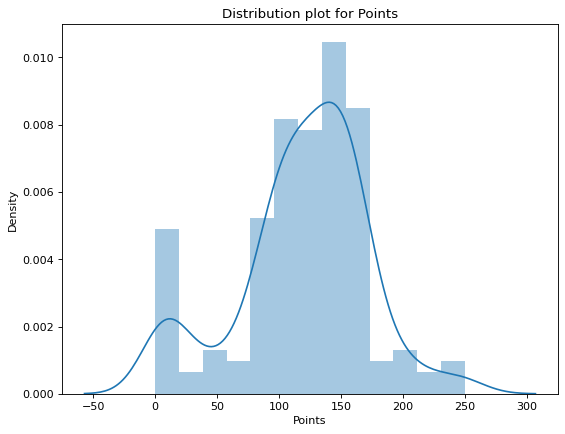

In [12]:
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(df.Points)
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Points")

Text(0.5, 1.0, 'Distribution plot for Square Root of Points')

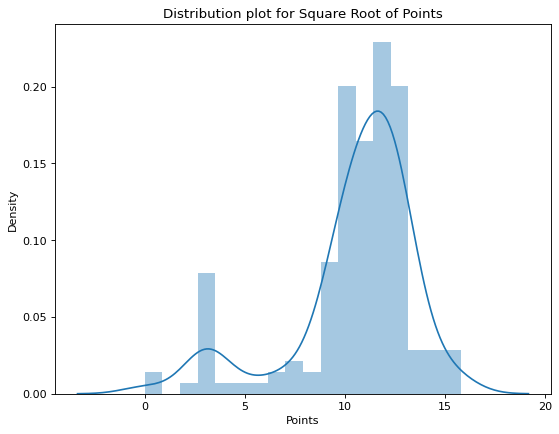

In [13]:
# The data shows some outliers. let's transform it and check
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(np.sqrt(df.Points))
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Square Root of Points")

Text(0.5, 1.0, 'Box Plot for Points')

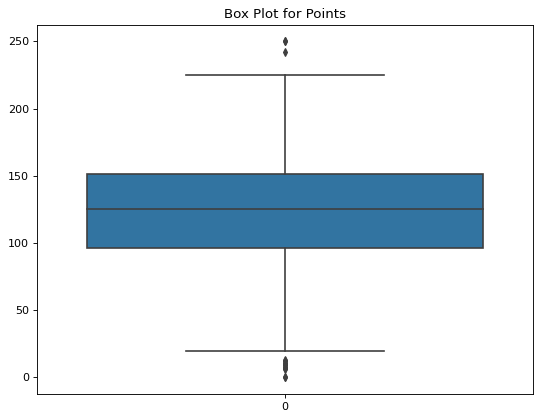

In [14]:
# Lets check the boxplot visualization of Points which tells us the outliers
figure(figsize=(8,6), dpi= 80)
sns.boxplot(df.Points)
plt.title("Box Plot for Points")

In [15]:
df.tail(100)

,Team,Points,WL,Yoga,Laps,WI,PAFS
59,Clippers,156,34.0,28.0,40.0,5.0,5.0
60,Clippers,122,37.0,29.0,44.0,5.0,2.0
61,Warriors,55,14.0,8.0,17.0,3.0,3.0
62,Warriors,60,14.0,8.0,17.0,3.0,4.0
63,Warriors,90,16.0,11.0,20.0,3.0,7.0
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,NaN
155,Bulls,13,12.0,12.0,14.0,1.0,NaN
156,Bulls,12,12.0,13.0,14.0,1.0,NaN
157,Bulls,20,13.0,14.0,15.0,1.0,6.0


In [16]:
# function for plotting violin plots to visualize the distribution and shape of the data
# plotting violin and boxplot side-by-side explains the outliers in a group
def plotting_box_violin_plots(df, x, y):
    fig, axes= plt.subplots(1,2, figsize=(18,10))
    fig.suptitle("Violin and box-plots for variable: {}".format(y))

    sns.violinplot(ax=axes[0], x=x, y=y, data=df)
    sns.boxplot(ax=axes[1], data=df[y])

    axes[0].set_title("Violin plot for variable: {}".format(y))
    axes[1].set_title("Box plot for variable: {}".format(y))




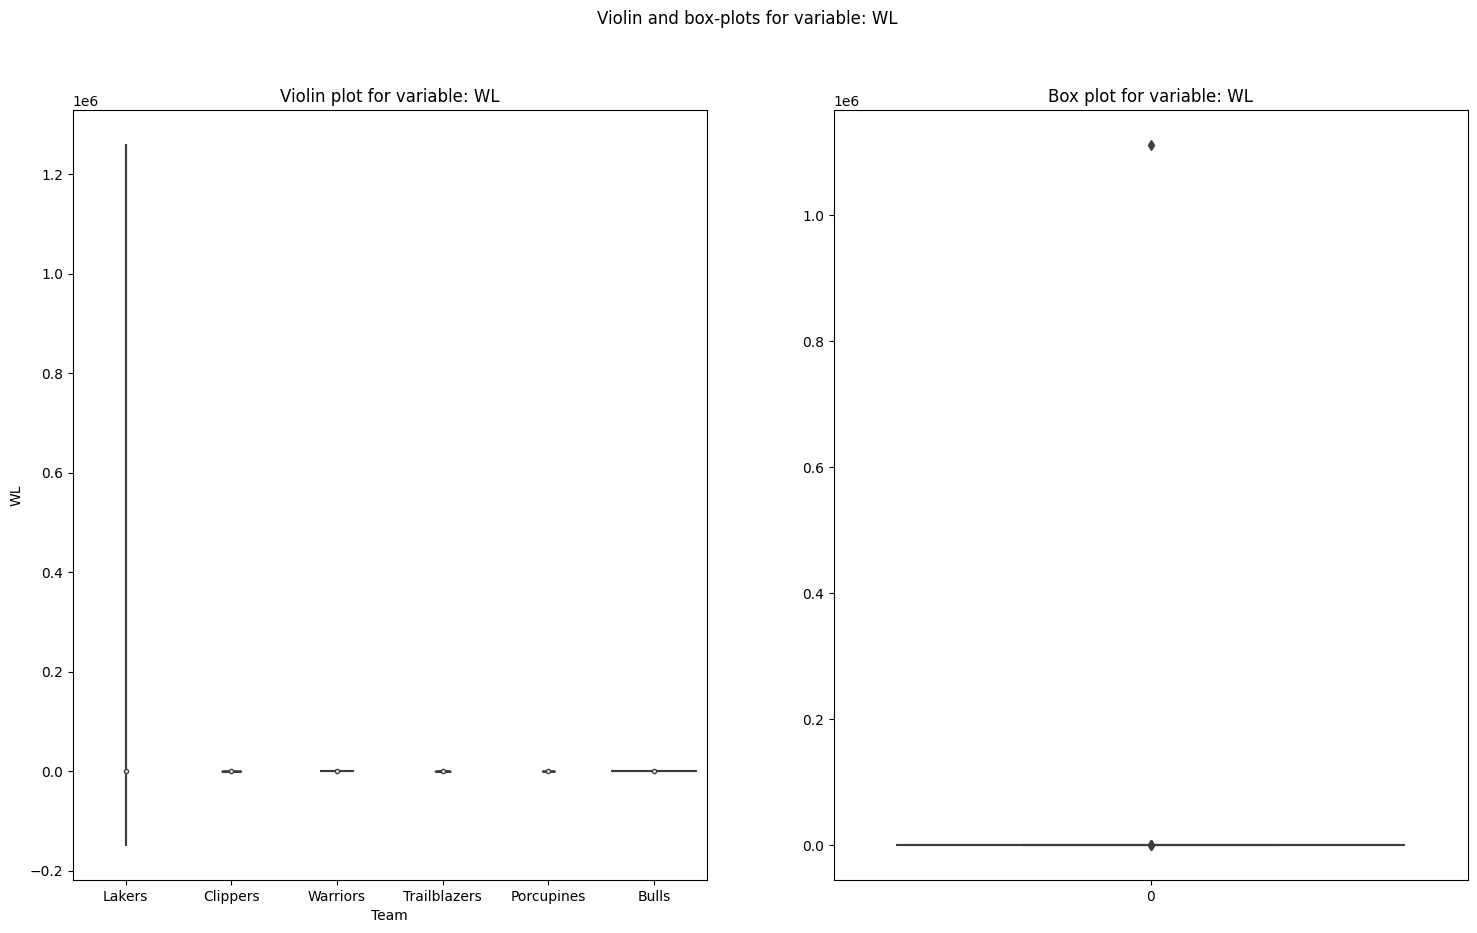

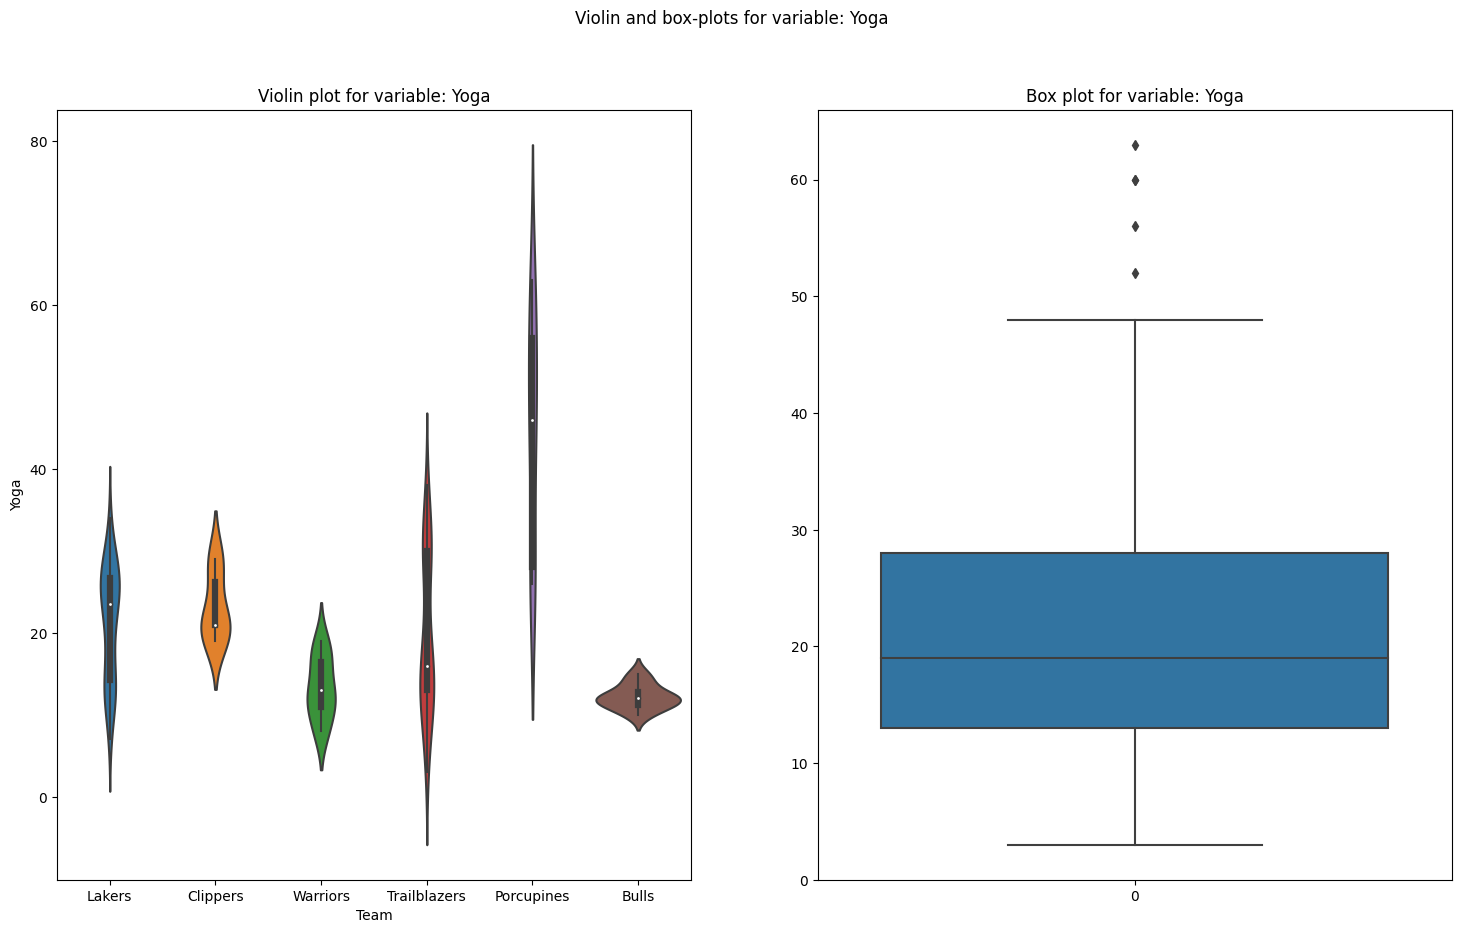

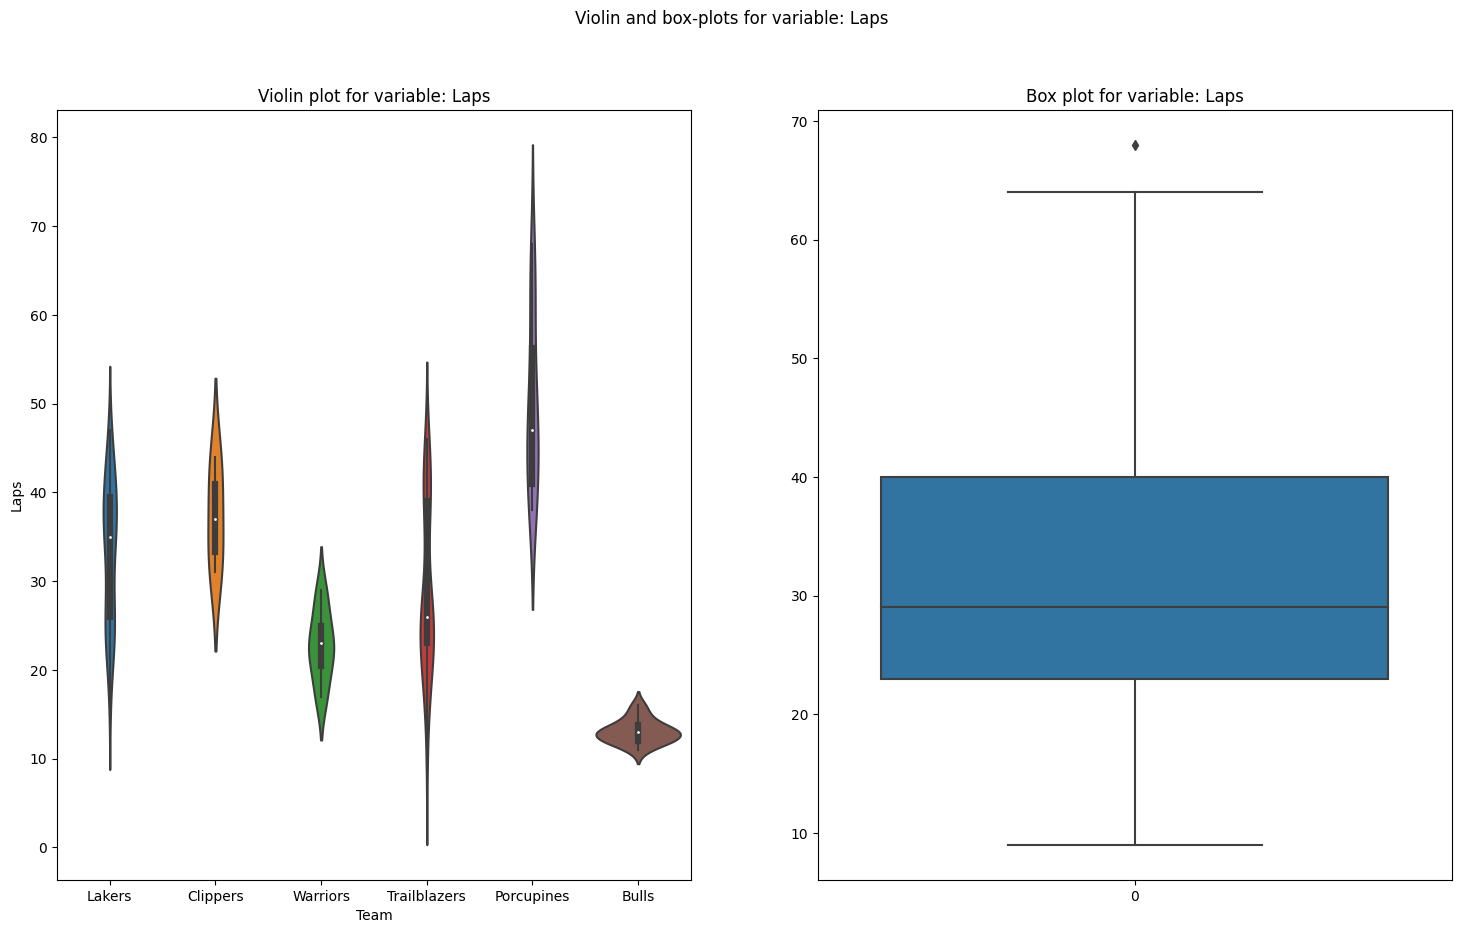

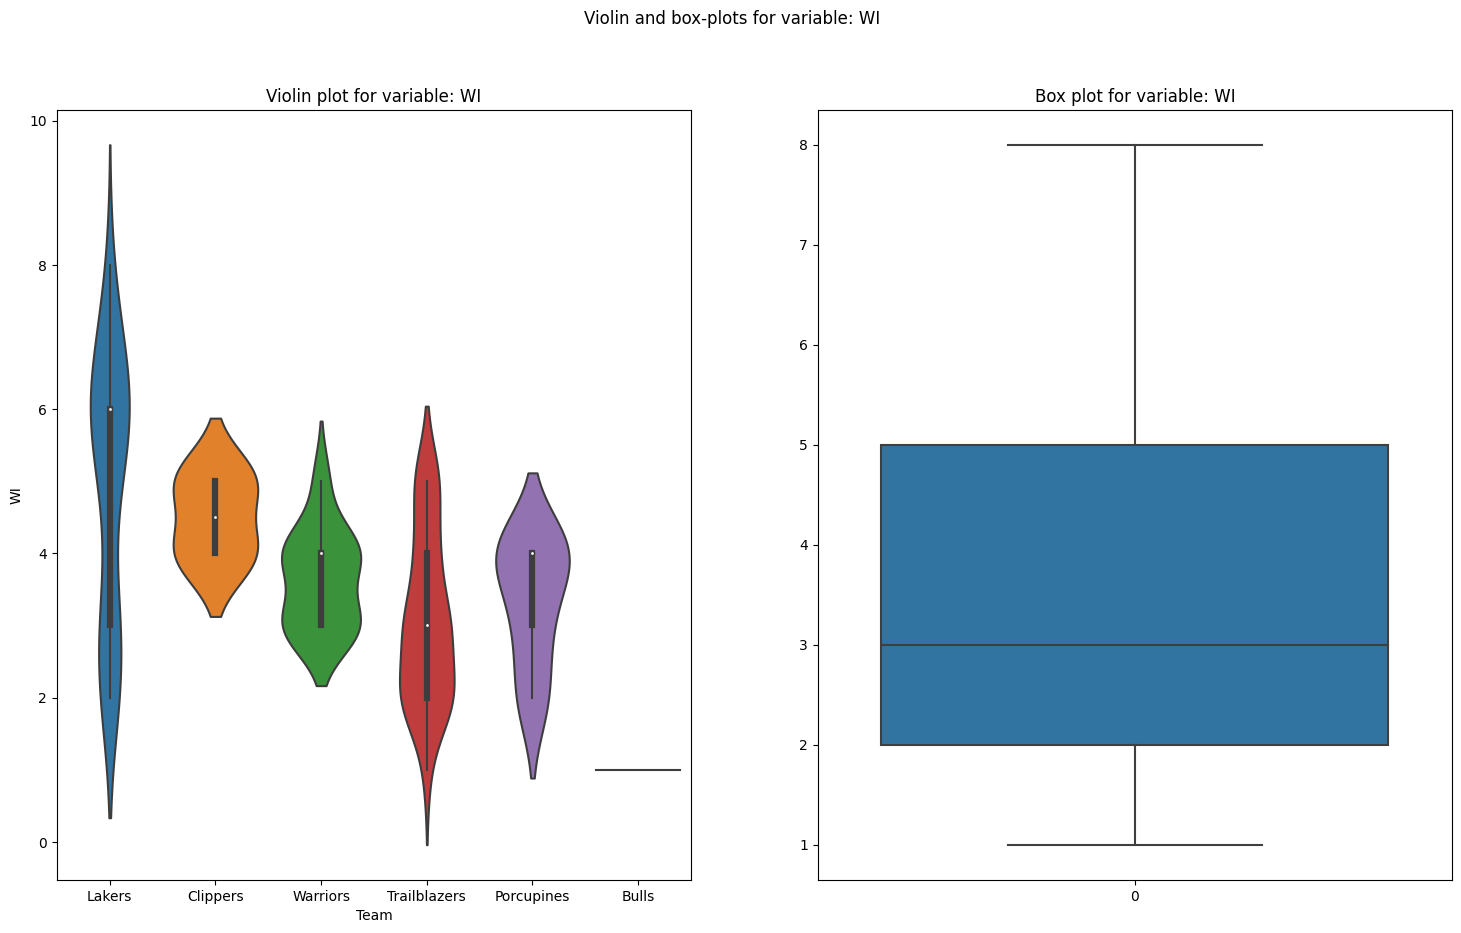

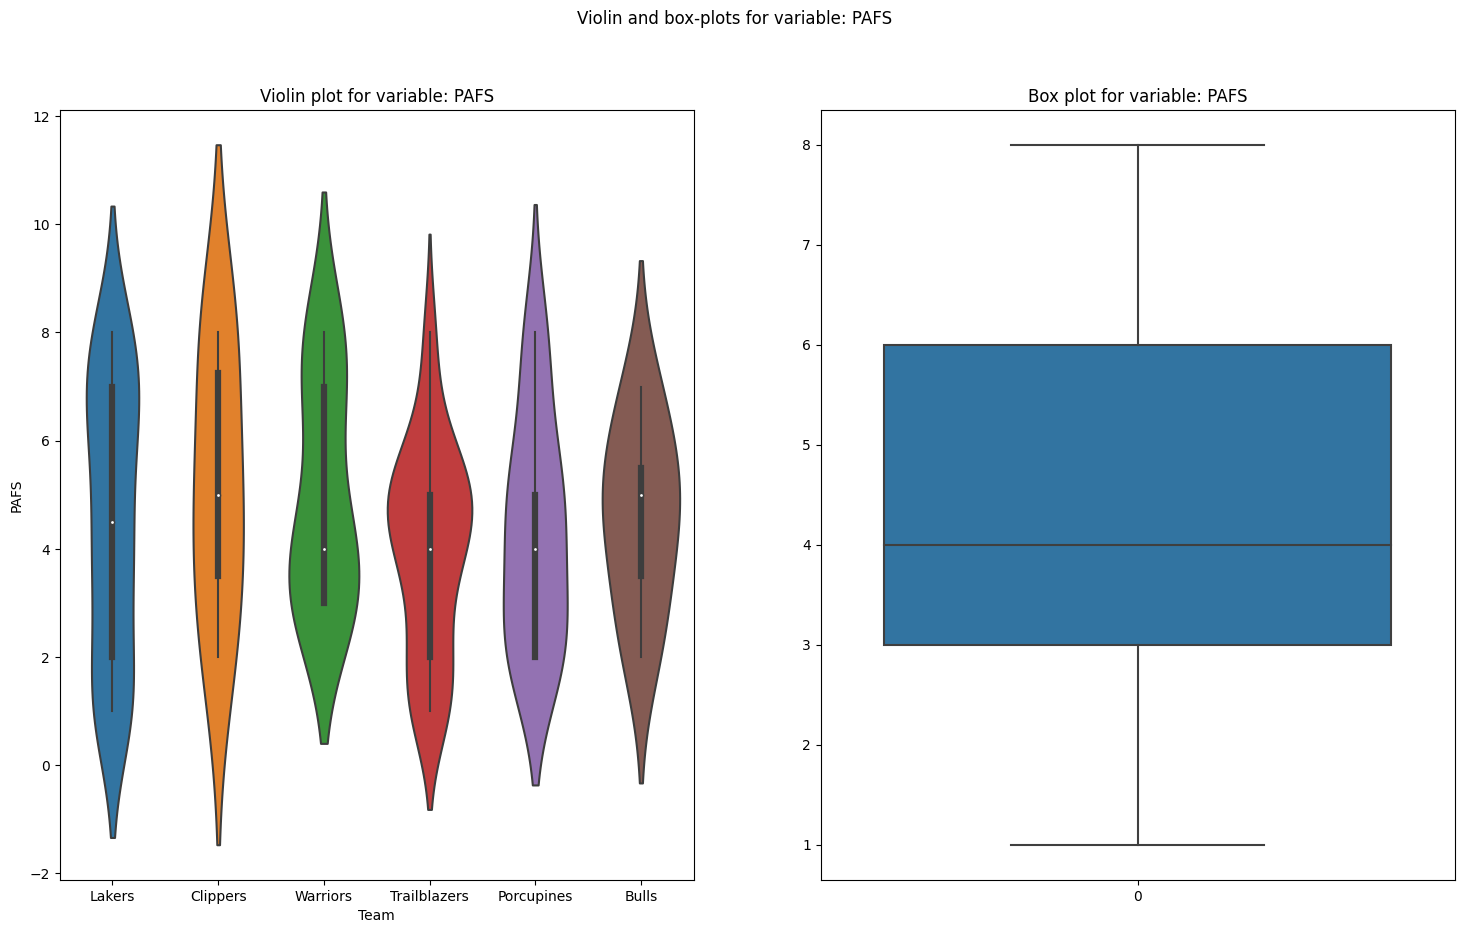

In [17]:
for x in ['WL','Yoga','Laps','WI','PAFS']:
  plotting_box_violin_plots(df,"Team",x)

**Finding Outliers using Inter Quartile Range**     
IQR is calculated as the difference between the 75th and 25th percentiles of the data, and outliers are considered to be any observations that fall below Q1-1.5(IQR) or above Q3+1.5(IQR). This method is based on the assumption that the data is approximately normally distributed

In [18]:
# function for finding out outliers
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_end = Q3 + 1.5*IQR
    lower_end = Q1 - 1.5*IQR

    outlier = df[column][(df[column]>upper_end) | (df[column]<lower_end)]

    return outlier

In [19]:
for column in ['WL','Yoga','Laps','WI','PAFS']:
    print("\n Outliers in column ", column)
    outlier = find_outliers(df, column)
    print(outlier)


 Outliers in column  WL
8      1111111.0
142         56.0
143         56.0
144         59.0
Name: WL, dtype: float64

 Outliers in column  Yoga
140    52.0
141    56.0
142    60.0
143    60.0
144    63.0
Name: Yoga, dtype: float64

 Outliers in column  Laps
144    68.0
Name: Laps, dtype: float64

 Outliers in column  WI
Series([], Name: WI, dtype: float64)

 Outliers in column  PAFS
Series([], Name: PAFS, dtype: float64)


In [20]:
# removing outliers as these rows are commonly acting as outlier in other features
df_clean = df.drop([142, 143, 144])
df_clean.shape

(156, 7)

In [21]:
# the row 8 in WL column has outlier, let's update it to NaN
df_clean['WL'][df_clean['WL'] == 1111111.0] = np.nan 
df_clean['WL'].head(10)

0    23.0
1    24.0
2    24.0
3    26.0
4    27.0
5    27.0
6    27.0
7    28.0
8     NaN
9    29.0
Name: WL, dtype: float64

In [22]:
ncounts = pd.DataFrame([df_clean.isna().mean()]).T

In [23]:
ncounts = ncounts.rename(columns={1:'data_missing'})
ncounts

,0
Team,0.000000
Points,0.000000
WL,0.064103
Yoga,0.128205
Laps,0.089744
WI,0.089744
PAFS,0.185897


<Axes: title={'center': '% of missing values across each column'}>

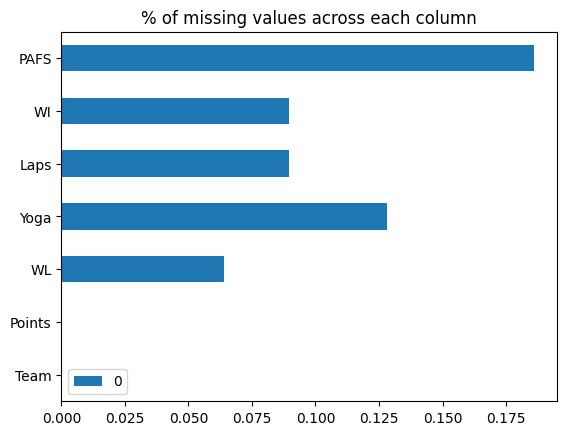

In [24]:
# plot of missing value in each column
ncounts.plot(kind= 'barh', title= '% of missing values across each column')

In [25]:
# let's compare
# if we have to remove the rows with null values, what would be the shape of our dataframe
df_clean.shape, df_clean.dropna(axis=0).shape

((156, 7), (94, 7))

In [26]:
# if we have to remove the columns with null values, what would be the shape of our dataframe
df_clean.shape, df_clean.dropna(axis=1).shape

((156, 7), (156, 2))

**Imputation Techniques**     
3 methods used here are:    
1. Pandas way -> F fill and B fill, groupby    
2. sklearn way -> imputer -> simple, iterative, knn    
3. LGBM -> to fill in the missing values

**Let's start with Pandas Imputer**

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 158
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    156 non-null    object 
 1   Points  156 non-null    int64  
 2   WL      146 non-null    float64
 3   Yoga    136 non-null    float64
 4   Laps    142 non-null    float64
 5   WI      142 non-null    float64
 6   PAFS    127 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 9.8+ KB


In [28]:
# filling missing values with -1
df_clean['WL'].fillna(-1)

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: WL, Length: 156, dtype: float64

Text(0.5, 1.0, 'Distribution Plot for WL')

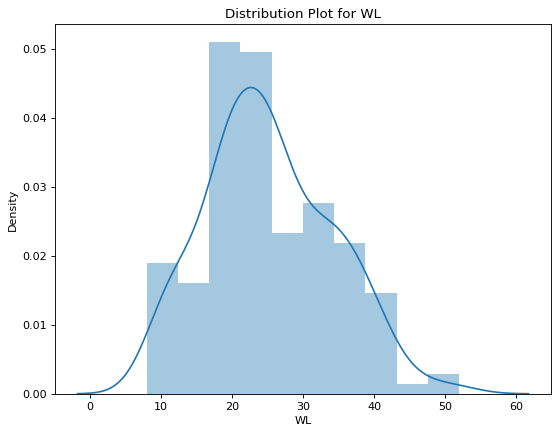

In [29]:
# visualizing after filling missing values with mean
figure(figsize=(8,6), dpi=80)
sns.distplot(df_clean['WL'].fillna(df_clean['WL'].mean()))
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution Plot for WL")

Text(0.5, 1.0, 'Distribution Plot for WL')

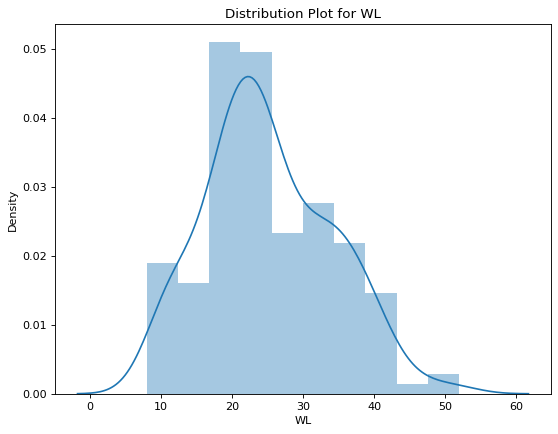

In [30]:
# visualizing after filling missing values with median
figure(figsize=(8,6), dpi=80)
sns.distplot(df_clean['WL'].fillna(df_clean['WL'].median()))
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution Plot for WL")

In [31]:
# group by team
mean_WL = df_clean.groupby("Team")['WL'].mean().to_dict()
mean_WL

{'Bulls': 11.214285714285714,
 'Clippers': 29.0,
 'Lakers': 26.04255319148936,
 'Porcupines': 39.42857142857143,
 'Trailblazers': 25.425925925925927,
 'Warriors': 18.727272727272727}

In [32]:
# replacing the null values in each group with its own mean value
WL_series = df_clean['WL'].replace(mean_WL)

Text(0.5, 1.0, 'Distribution plot WL after replacing the null with its group mean')

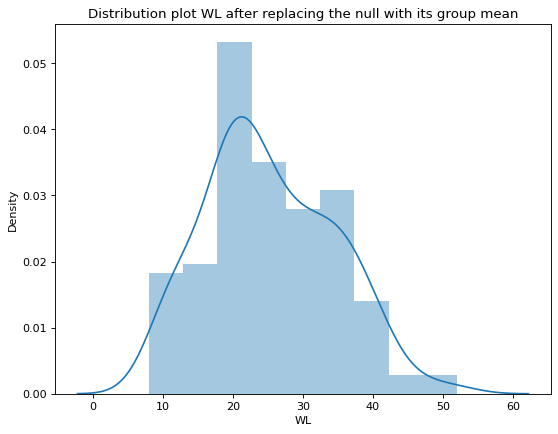

In [33]:
figure(figsize=(8,6), dpi=80)
sns.distplot(WL_series)
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution plot WL after replacing the null with its group mean")

In [34]:
df_clean['WL'].replace(mean_WL)

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: WL, Length: 156, dtype: float64

**Sklearn Imputer**    
The main imputers provided by this module are:    
* SimpleImputer    
* IterativeImputer    
* KNN imputation

In [35]:
# 1. simple imputer
Features = ['WL','Yoga','Laps','WI','PAFS']

In [36]:
from sklearn.impute import SimpleImputer
impt = SimpleImputer(strategy='mean')

#fit and transform
si_impt = impt.fit_transform(df_clean[Features])
si_impt_df = pd.DataFrame(si_impt, columns=Features)

si_impt_df
# notice the rows where the null values are imputed

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,20.823529,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.417323
152,12.0,12.000000,14.0,1.0,4.417323
153,12.0,13.000000,14.0,1.0,4.417323
154,13.0,14.000000,15.0,1.0,6.000000


In [37]:
#2. Iterative Imputer
ITI = IterativeImputer(max_iter=10)

# fit and transform
ITI_impt = ITI.fit_transform(df_clean[Features])

ITI_impt_df = pd.DataFrame(ITI_impt, columns=Features)

ITI_impt_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,22.063002,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.413163
152,12.0,12.000000,14.0,1.0,4.413298
153,12.0,13.000000,14.0,1.0,4.413450
154,13.0,14.000000,15.0,1.0,6.000000


In [38]:
#3. KNN Imputer
from sklearn.impute import KNNImputer
KNN = KNNImputer(n_neighbors = 3)

# fit and transform
KNN_impt = KNN.fit_transform(df_clean[Features])
KNN_impt_df = pd.DataFrame(KNN_impt, columns=Features)

KNN_impt_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,22.666667,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.666667
152,12.0,12.000000,14.0,1.0,5.333333
153,12.0,13.000000,14.0,1.0,6.000000
154,13.0,14.000000,15.0,1.0,6.000000


**LGBM Imputer**     
LGBMImputer is a data imputation technique fro the python project *kuma_utils*, available at https://github.com/analokmaus/kuma_utils.git     
This is designed to fill in missing values in a dataset using gradient boosting decision trees. This technique is a variation of tree-based imputation, which uses regression trees to make predictions for missing values based on the values of other variables in the dataset.    

The LGBMImputer class takes in a dataset and a list of columns to be imputed as inputs. It then fits a LightGBM model to the data, with the target variable being the missing values and the features being the remaining variables. After training, the model is used to predict the missing values.

One advantage of LGBMImputer is that it is able to handle both categorical and numerical data, unlike some other imputation techniques that are only suitable for one or the other. Additionally, LightGBM is a fast and efficient algorithm, so LGBMImputer is able to handle large datasets with many missing values quickly.

In [39]:
# clone the repository
!git clone https://github.com/analokmaus/kuma_utils.git

fatal: destination path 'kuma_utils' already exists and is not an empty directory.


In [40]:
# add to path
sys.path.append('kuma_utils/')

In [41]:
from kuma_utils.preprocessing.imputer import LGBMImputer

In [42]:
%%time
lgbm = LGBMImputer(n_iter=100, verbose=True)

#fit and transform
lgbm_itr = lgbm.fit_transform(df_clean[Features])

lgbm_itr_df = pd.DataFrame(lgbm_itr, columns=Features)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 156 ms, sys: 364 ms, total: 520 ms
Wall time: 383 ms


In [43]:
lgbm_itr_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,24.357742,34.0,5.0,6.000000
...,...,...,...,...,...
154,12.0,12.000000,13.0,1.0,3.805411
155,12.0,12.000000,14.0,1.0,3.805411
156,12.0,13.000000,14.0,1.0,3.953409
157,13.0,14.000000,15.0,1.0,6.000000


In [44]:
# let's consider this as our new dataframe which has no null values
df_new = lgbm_itr_df

**Univariate Analysis**      
This is an important step in the data exploration process, as it helps to identify any outliers, skewness, or patterns in the data that may impact further analysis or modeling.

In [45]:
df_new.columns

Index(['WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object')

<Axes: xlabel='WL', ylabel='Density'>

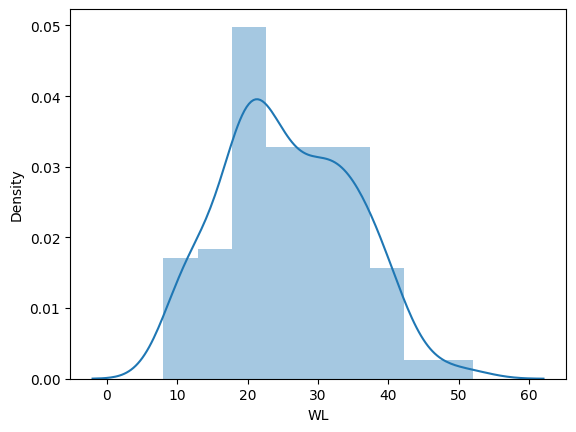

In [46]:
# distribution of WL
sns.distplot(df_new['WL'])

<Axes: xlabel='WL', ylabel='Density'>

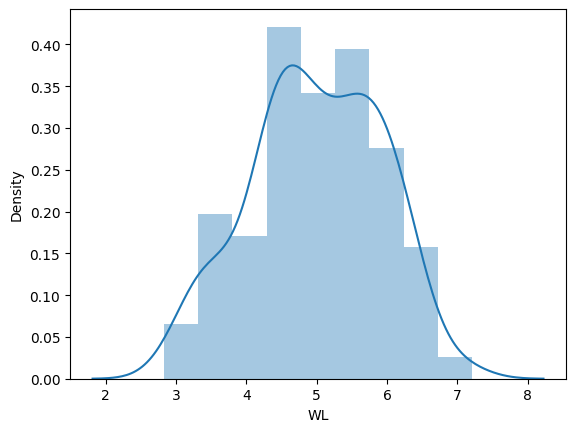

In [47]:
# let transform the WL to sqrt(WL)
sns.distplot(np.sqrt(df_new['WL']))

<Axes: >

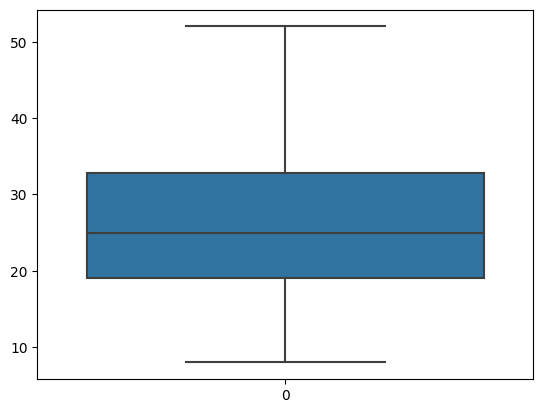

In [48]:
# boxplot of WL
sns.boxplot(df_new['WL'])

<Axes: >

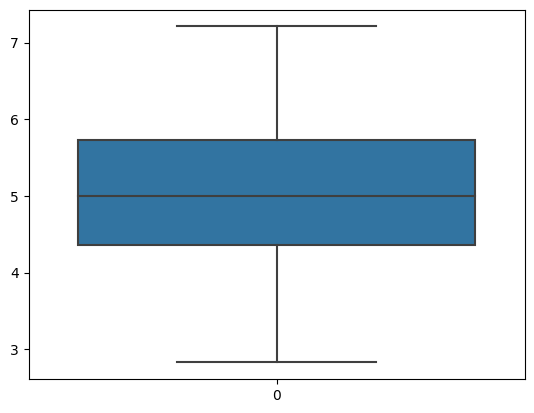

In [49]:
# boxplot of sqrt(WL)
sns.boxplot(np.sqrt(df_new["WL"]))

This transformation looks good

<Axes: >

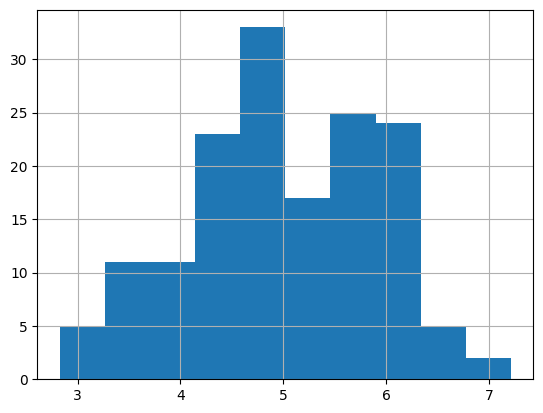

In [50]:
# histogram plot of sqrt(WL)
np.sqrt(df_new['WL']).hist()

<Axes: >

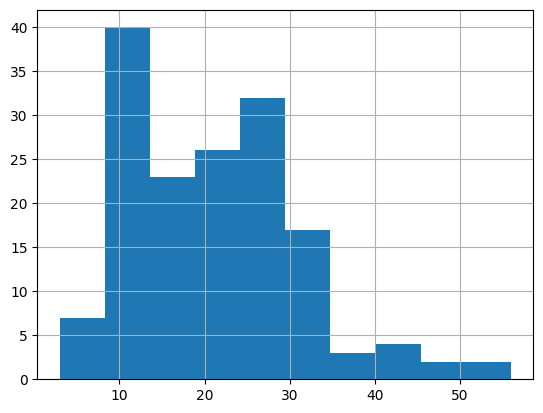

In [51]:
# let's check another imputed variable Yoga
df_new['Yoga'].hist()

<Axes: xlabel='Yoga', ylabel='Density'>

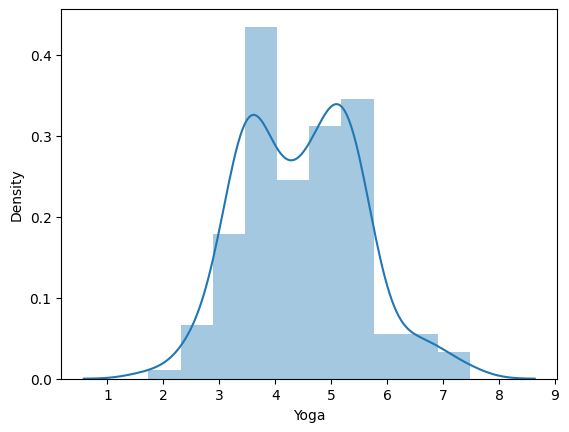

In [52]:
# distribution of sqrt(Yoga)
sns.distplot(np.sqrt(df_new['Yoga']))

<Axes: xlabel='PAFS', ylabel='Density'>

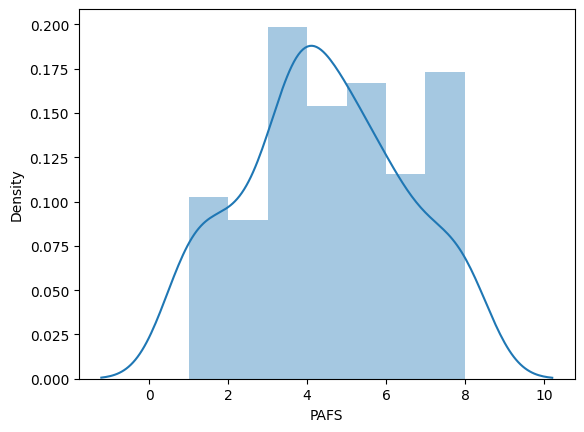

In [53]:
# distribution of PAFS
sns.distplot(df_new['PAFS'])

<Axes: xlabel='PAFS', ylabel='Density'>

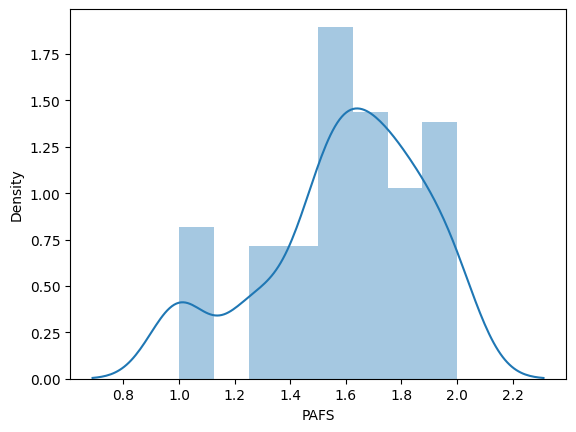

In [54]:
# distribution of cbrt(PAFS)
sns.distplot(np.cbrt(df_new['PAFS']))

**Bivariate Analysis**     
The goal here is to identify patterns and relationships in data that can be used to make predictions or draw conclusions

In [55]:
# bivariate analysis
# 1. Linear correlation -> Pearson's and Spearman's
# 2. Non linear -> Chatterjee correlations

In [56]:
df_clean.shape, df_new.shape

((156, 7), (156, 5))

In [57]:
# two columns are missing in new df
df_clean.columns, df_new.columns

(Index(['Team', 'Points', 'WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object'),
 Index(['WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object'))

In [58]:
df_new['Points'] = df_clean["Points"]
df_new['Team'] = df_clean['Team']

In [59]:
df_new.head()

,WL,Yoga,Laps,WI,PAFS,Points,Team
0,23.0,25.000000,30.0,5.0,4.0,242,Lakers
1,24.0,26.000000,31.0,5.0,8.0,144,Lakers
2,24.0,27.000000,31.0,5.0,7.0,156,Lakers
3,26.0,29.000000,34.0,5.0,1.0,159,Lakers
4,27.0,24.357742,34.0,5.0,6.0,106,Lakers


In [60]:
df_new.loc[:,['WL','Yoga','Laps','WI','PAFS', 'Points']].corr()

,WL,Yoga,Laps,WI,PAFS,Points
WL,1.000000,0.940899,0.989656,0.716546,0.001012,0.448556
Yoga,0.940899,1.000000,0.927862,0.617798,0.026512,0.343593
Laps,0.989656,0.927862,1.000000,0.776036,0.024935,0.479233
WI,0.716546,0.617798,0.776036,1.000000,0.129837,0.425148
PAFS,0.001012,0.026512,0.024935,0.129837,1.000000,0.048566
Points,0.448556,0.343593,0.479233,0.425148,0.048566,1.000000


Text(0.5, 1.0, 'Linear Correlation Matrix')

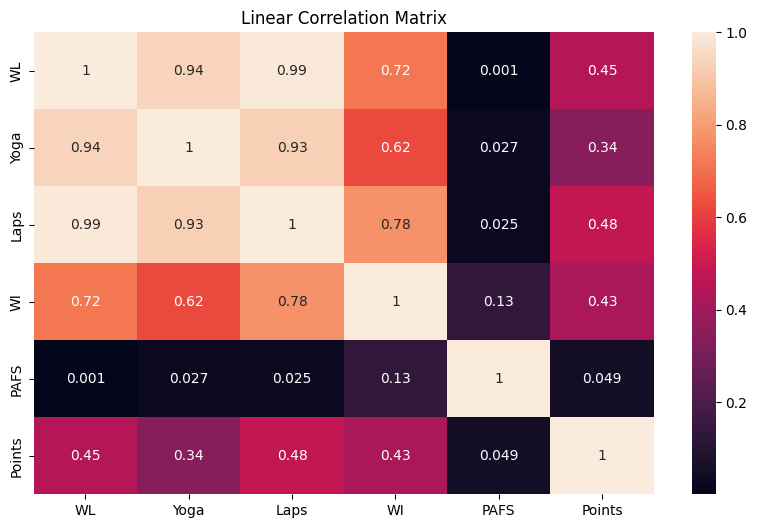

In [61]:
#heatmap of correlation matrix
plt.rcParams["figure.figsize"]=(10,6)

sns.heatmap(df_new.loc[:,['WL','Yoga','Laps','WI','PAFS', 'Points']].corr(), annot=True)
plt.title("Linear Correlation Matrix")

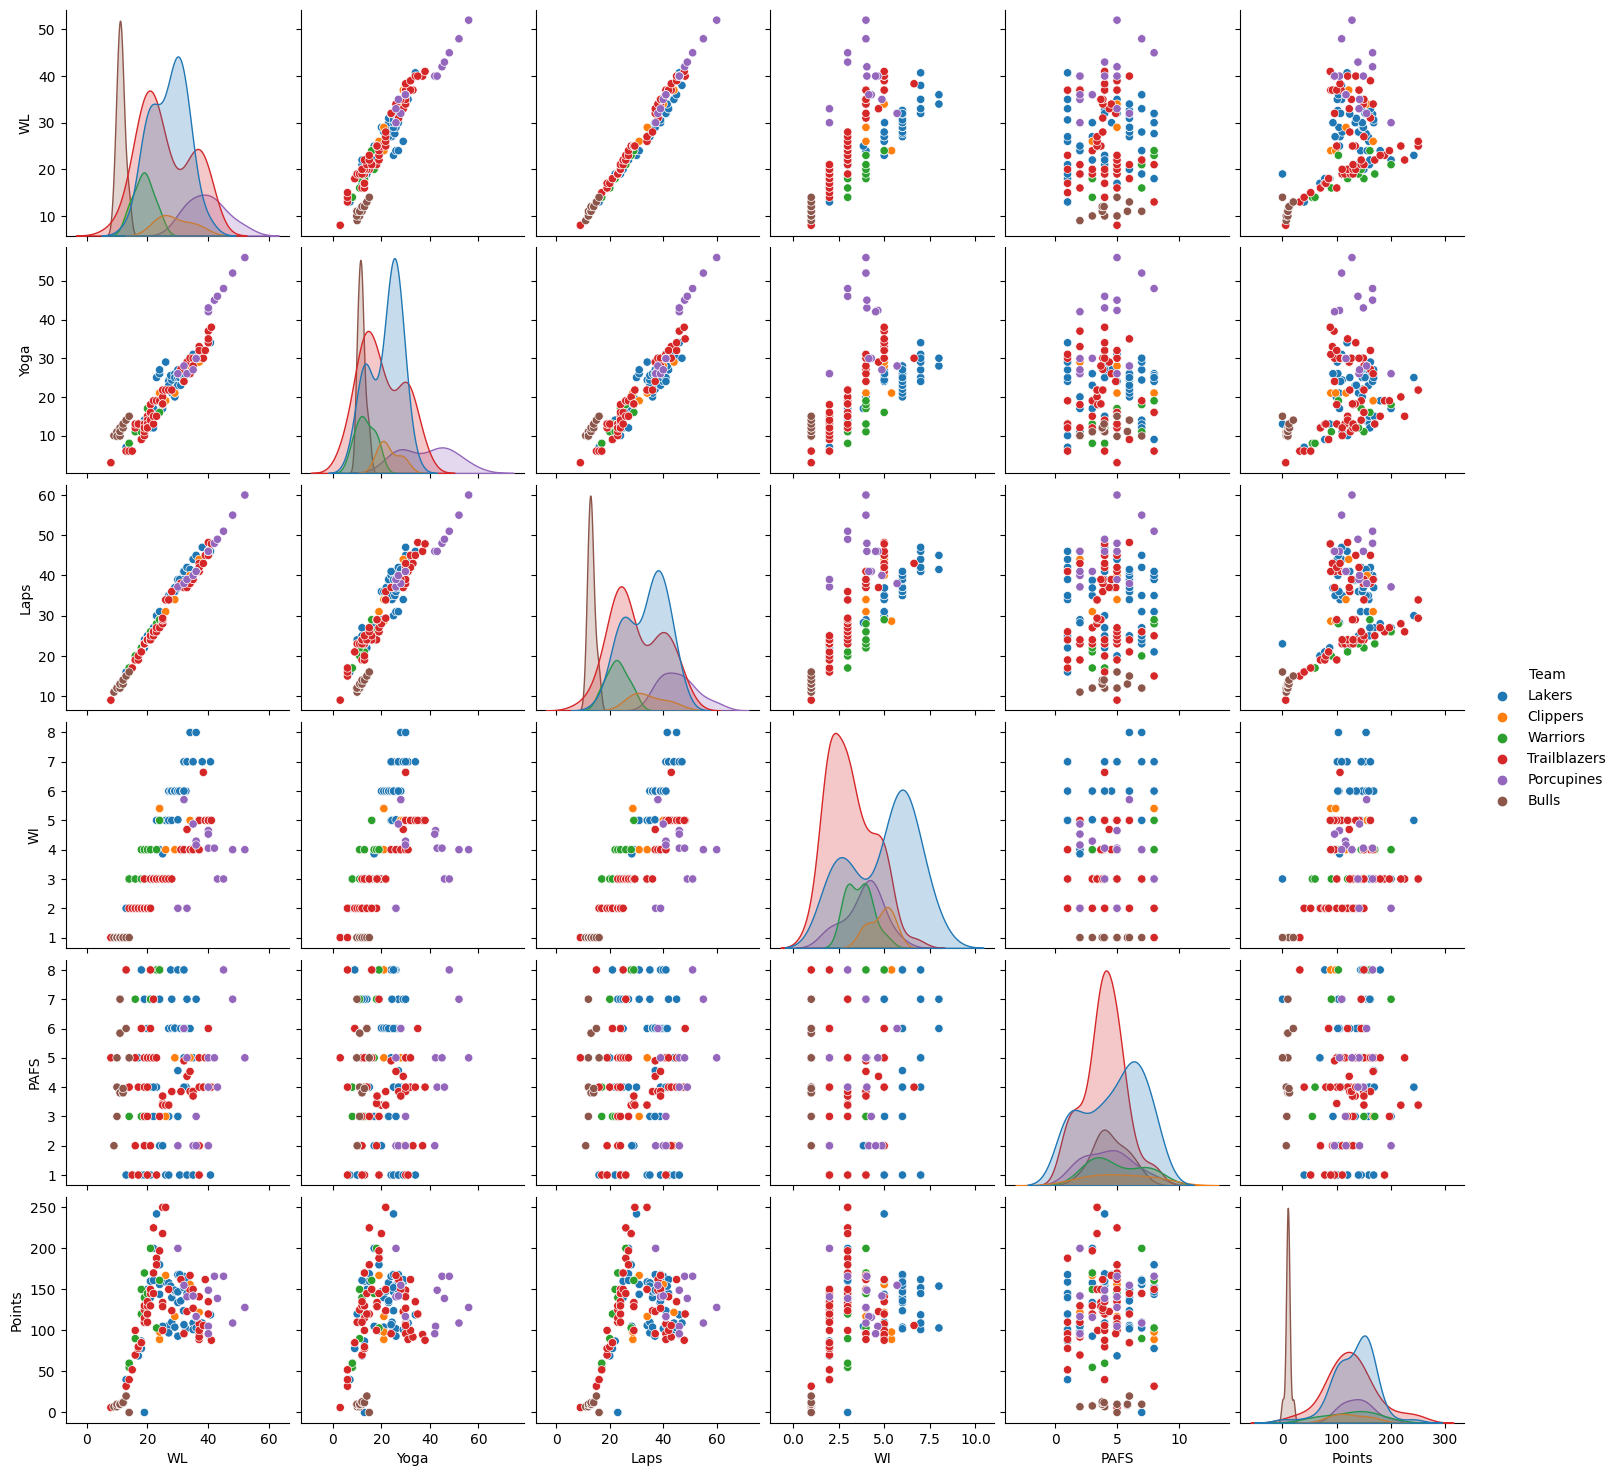

In [62]:
# pairplot of the data
sns.pairplot(df_new, kind='scatter', hue='Team')

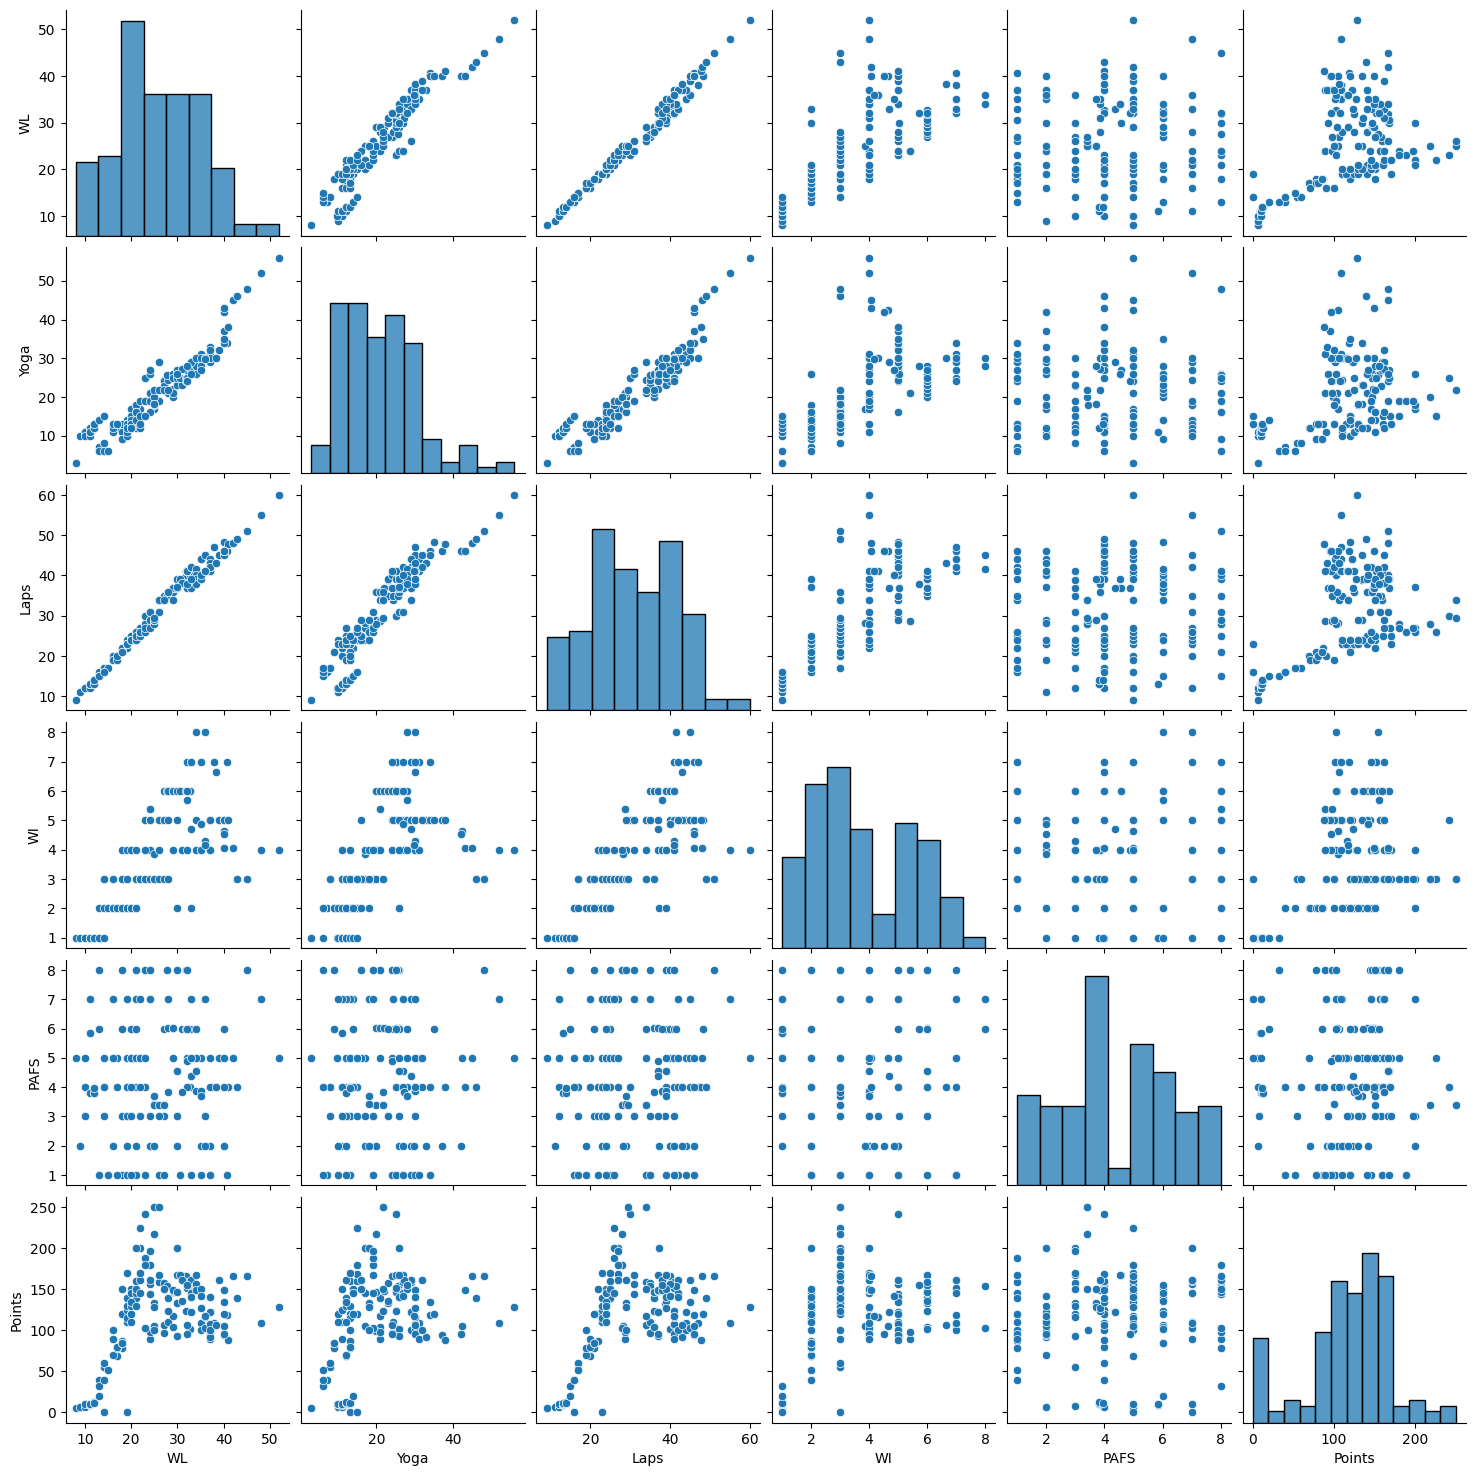

In [63]:
# scatter pairplot
sns.pairplot(df_new, kind='scatter')

**Chatterjee Correlation**    
Chatterjee correlation is a coefficient of correlation proposed by Sourav Chatterjee that measure the degree of dependence between two random variables without assuming anything about their distributions. It is a simple and interpretable measure of dependence that ranges between 0 and 1, where 0 indicate independence and 1 indicates that one variable is a measurable function of the other.    

Compared to other correlation coefficients, the Chatterjee correlation is less sensitive to outliers and non-linear relationships between variables. However, it requires more computational resources due to its non-parametric nature.    

The calculation involves the following steps:    
* Rank the Y values in the dataset, assigning the smallest value the rank of 1, the second smallest to rank of 2, and so on. Store these ranks in a new column called 'rank'.     
* Rank the X values in the dataset, in similar order, and store these ranks in a new column 'rank_x'.    
* Sort the dataset in increasing order of rank_x.    
* Calculate the absolute difference between the ranks of Y for consecutive X values. Sum up these differences.    
* Calculate the Chatterjee correlation coefficient using the formula:    
   Chatterjee correlation coefficient = 1 - 3 *(summ of absolute differences in ranks) / (N^2 -1), where N is the number of observations in the datset.     


In [64]:
# function to find Chatterjee correlation coefficient
def chatterjee_corr(df, x, y):
    N = df.shape[0]
    df_rank = df

    df_rank['rank'] = df_rank[y].rank()
    df_rank['rank_x'] = df_rank[x].rank()

    df_rank = df_rank.sort_values(by='rank_x')

    chatt_corr = 1 - (3 * df_rank['rank'].diff().abs().sum()) / (pow(N,2) - 1)

    return chatt_corr

In [65]:
chatterjee_corr(df_new, 'WL', 'Points')

0.4062872405999589

In [66]:
chatterjee_corr(df_new, 'WI', 'Points')

0.39198685021573865

In [67]:
chatterjee_corr(df_new, 'Laps', 'Points')

0.4229299363057325

In [68]:
chatterjee_corr(df_new, 'PAFS', 'Points')

0.0019930141771111742

In [69]:
chatterjee_corr(df_new, 'Yoga', 'Points')

0.2911444421614958

Determining whether Team essentially affects the Points variable for the dataset

**Single Way ANOVA**    
The null hypothesis for ANOVA is that all groups have the same mean, while the alternative hypothesis is that atleast one group has a different mean. The test calculates F values, which are the ratio of the between group mean squares and within groups mean squares, and p-values.     

The F value is used to determine whether or not the means of the groups are significantly different, while the p-value is used to determine the probability of obtaining a certain F value by chance.     

It is important to note that ANOVA only tells you that there is a difference between groups, but not where the difference is. 

In [70]:
import random

nba_id = list(df_new.index.unique())

random.seed(13)

sample_match_id = random.sample(nba_id, 50)

In [71]:
sample_df = df_new[df_new.index.isin(sample_match_id)].reset_index(drop=True)

sample_df.head()

,WL,Yoga,Laps,WI,PAFS,Points,Team,rank,rank_x
0,26.000000,29.000000,34.0,5.0,1.000000,159,Lakers,126.5,126.0
1,28.000000,24.366748,35.0,5.0,7.000000,110,Lakers,62.5,98.0
2,29.000000,25.000000,37.0,6.0,6.014168,149,Lakers,110.0,101.5
3,30.000000,25.000000,39.0,6.0,8.000000,147,Lakers,106.0,101.5
4,32.712197,28.000000,39.0,6.0,4.000000,155,Lakers,121.5,121.0


In [72]:
sample_df = sample_df[['Team', 'Points']]
groups = sample_df.groupby('Team').count().reset_index()

In [73]:
groups

,Team,Points
0,Bulls,5
1,Clippers,4
2,Lakers,14
3,Porcupines,3
4,Trailblazers,20
5,Warriors,4


In [74]:
## To check Normality
import scipy.stats as stats

unique_teams = sample_df['Team'].unique()
unique_teams

array(['Lakers', 'Clippers', 'Warriors', 'Trailblazers', 'Porcupines',
       'Bulls'], dtype=object)

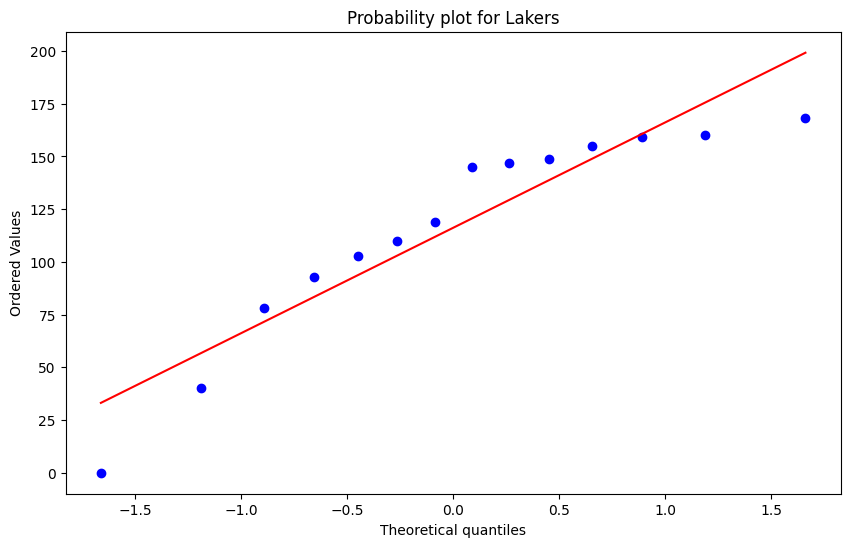

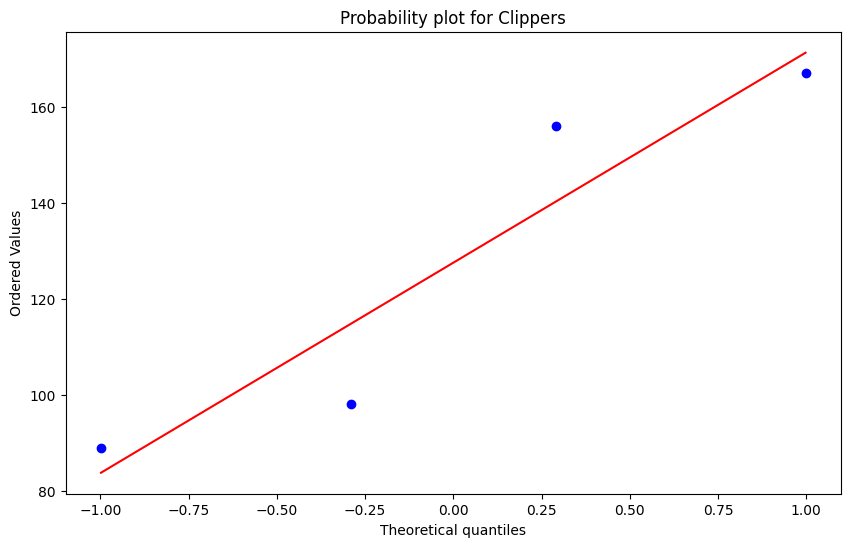

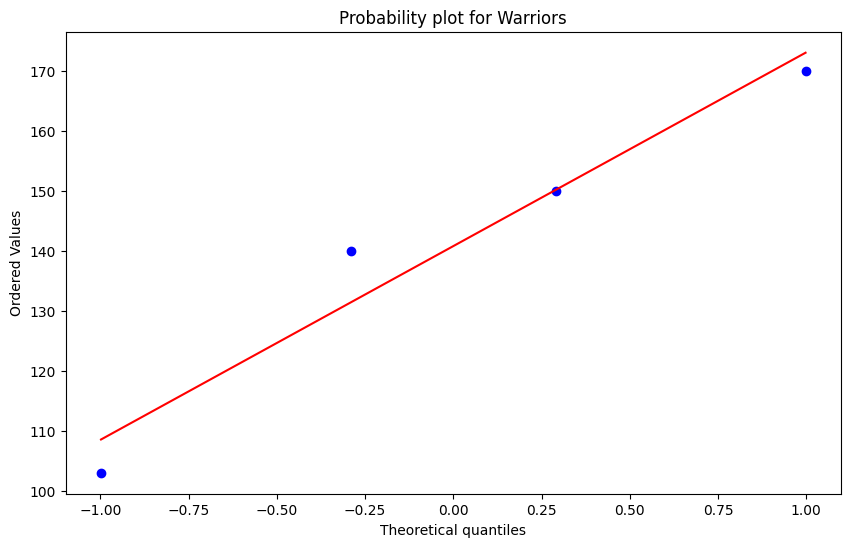

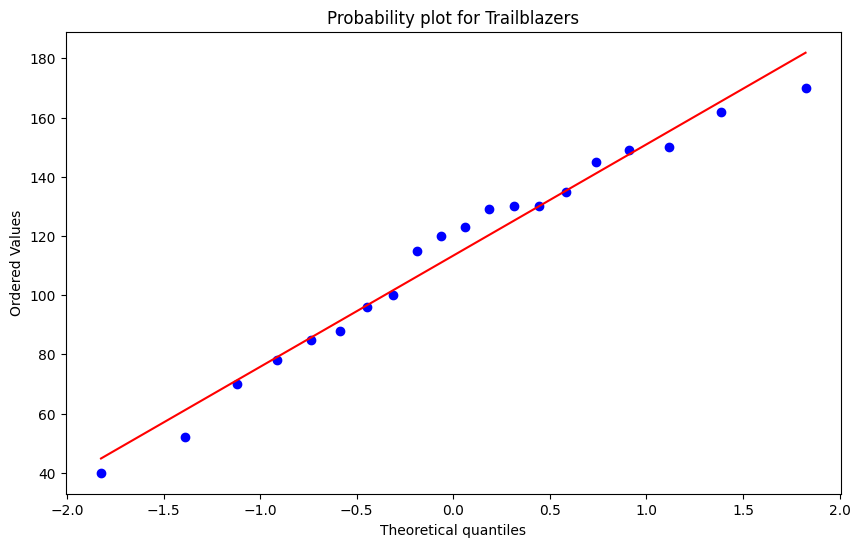

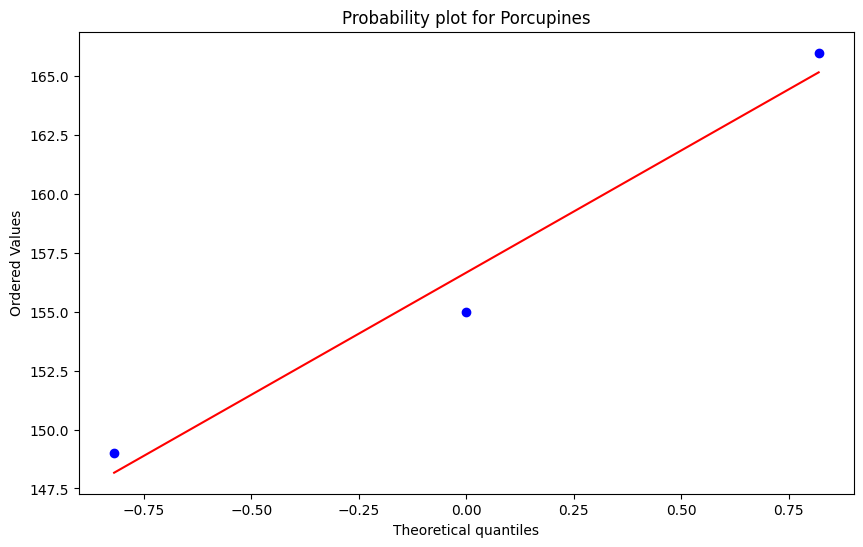

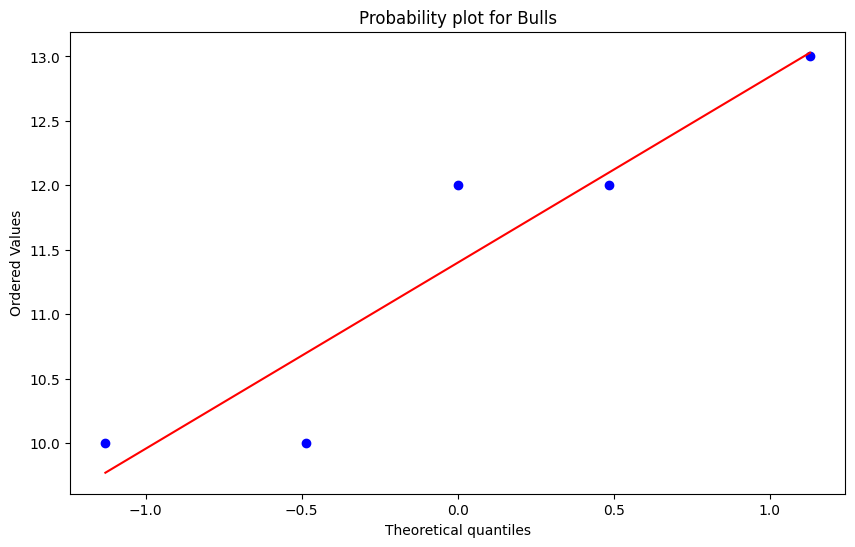

In [75]:
# quantile plots
for team in unique_teams:
    stats.probplot(sample_df[sample_df['Team'] == team]['Points'], dist='norm', plot=plt)
    plt.title('Probability plot for ' + team)
    plt.show()

In [76]:
ratio = sample_df.groupby('Team').std().max() / sample_df.groupby('Team').std().min()
ratio

Points    37.164289
dtype: float64

In [77]:
# implement ANOVA table
data = [['Between Groups', '','','','','',''], ['Within Groups', '','','','','',''], ['Total', '','','','','','']]

anova_table = pd.DataFrame(data, columns=['Variation', 'SS', 'df', 'MS', 'F-value', 'p-value', 'F-critical'])

anova_table.set_index('Variation', inplace=True)

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,,,,,,
Within Groups,,,,,,
Total,,,,,,


In [78]:
x_bar = sample_df['Points'].mean()

# Porcupines -2 overall 10 8
SSTR = sample_df.groupby('Team').count()*(sample_df.groupby('Team').mean() - x_bar)**2

In [79]:
anova_table['SS']['Between Groups'] = SSTR['Points'].sum()
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,,,,,,
Total,,,,,,


In [80]:
SSE = (sample_df.groupby('Team').count() - 1)*sample_df.groupby('Team').std()**2
SSE

,Points
Team,
Bulls,7.200000
Clippers,4725.000000
Lakers,32319.714286
Porcupines,148.666667
Trailblazers,24798.550000
Warriors,2366.750000


In [81]:
anova_table['SS']['Within Groups'] = SSE['Points'].sum()
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,64365.880952,,,,,
Total,,,,,,


In [82]:
total = SSE['Points'].sum() + SSTR['Points'].sum()
anova_table['SS']['Total'] = total
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,64365.880952,,,,,
Total,125268.02,,,,,


In [83]:
anova_table['df']['Between Groups'] = sample_df['Team'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['Team'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,,,,
Within Groups,64365.880952,44,,,,
Total,125268.02,49,,,,


In [84]:
anova_table['MS'] = anova_table['SS'] / anova_table['df']
anova_table['F-value']['Between Groups'] = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['p-value']['Between Groups'] = 1 - stats.f.cdf(anova_table['F-value']['Between Groups'], anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,12180.42781,8.326443,0.000013,
Within Groups,64365.880952,44,1462.860931,,,
Total,125268.02,49,2556.490204,,,


In [85]:
alpha = 0.05
hypothesis_type = 'two-tailed'

if hypothesis_type == 'two-tailed':
    alpha = alpha/2

anova_table['F-critical']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,12180.42781,8.326443,0.000013,2.871184
Within Groups,64365.880952,44,1462.860931,,,
Total,125268.02,49,2556.490204,,,


**Interpretation of the above ANOVA results**

In [86]:
# 2 ways
# 1. p-value approach
print("Approach for p-value")
conclusion = "Failed to reject null hypothesis"

if anova_table['p-value']['Between Groups'] <= alpha:
    conclusion = 'Null Hypothesis is rejected'

print('F-value is ', anova_table['F-value']['Between Groups'], "and p-value is ", anova_table['p-value']['Between Groups'])

print(conclusion)

Approach for p-value
F-value is  8.326442762673361 and p-value is  1.3292810565279645e-05
Null Hypothesis is rejected


In [87]:
# 2. f-critical approach
print("Approach for F-critical")
conclusion = "Failed to reject null hypothesis"

if anova_table['F-value']['Between Groups'] > anova_table['F-critical']['Between Groups']:
    conclusion = 'Null hypothesis is rejected'

print('F value is ', anova_table['F-value']['Between Groups'], "and F-critical is ", anova_table['F-critical']['Between Groups'])

print(conclusion)

Approach for F-critical
F value is  8.326442762673361 and F-critical is  2.871183837102218
Null hypothesis is rejected


**Data Processing**

In [88]:
#One-hot encoding 
one_hot_df = pd.get_dummies(df_clean, columns=['Team'], drop_first=True)
one_hot_df.head()

,Points,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
0,242,23.0,25.0,30.0,5.0,4.0,0,1,0,0,0
1,144,24.0,26.0,31.0,5.0,8.0,0,1,0,0,0
2,156,24.0,27.0,31.0,5.0,7.0,0,1,0,0,0
3,159,26.0,29.0,34.0,5.0,1.0,0,1,0,0,0
4,106,27.0,NaN,34.0,5.0,6.0,0,1,0,0,0


In [89]:
X = one_hot_df[['WL', 'Yoga', 'Laps', 'WI', 'PAFS', 'Team_Clippers', 'Team_Lakers', 'Team_Porcupines', 'Team_Trailblazers', 'Team_Warriors']]

y = one_hot_df['Points']

In [102]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('X train dimension is ', X_train.shape)
print('X test dimension is ', X_test.shape)
print('y train dimension is ', y_train.shape)
print('y test dimension is ', y_test.shape)

X train dimension is  (124, 10)
X test dimension is  (32, 10)
y train dimension is  (124,)
y test dimension is  (32,)


In [103]:
# check null values
X_train.isna().sum()

WL                    8
Yoga                 13
Laps                 12
WI                    9
PAFS                 23
Team_Clippers         0
Team_Lakers           0
Team_Porcupines       0
Team_Trailblazers     0
Team_Warriors         0
dtype: int64

In [104]:
# imputing null values
imputer = LGBMImputer(n_iter=15, verbose=True)

X_train_full = imputer.fit_transform(X_train)
X_train_clean = pd.DataFrame(X_train_full, columns=X_train.columns)
X_train_clean.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
140,48.0,52.000000,55.000000,4.000000,7.000000,0,0,1,0,0
136,40.0,43.000000,46.000000,4.134609,4.000000,0,0,1,0,0
43,20.0,14.000000,25.000000,2.000000,6.000000,0,1,0,0,0
114,35.0,30.000000,39.000000,4.000000,4.091483,0,0,0,1,0
105,25.0,21.697177,28.956413,3.000000,4.059000,0,0,0,1,0


**Modeling**

**Create a dataframe to store model results**

In [123]:
metrics_columns = ['model_name', 'model_summary', 'mean_absolute_error', 'rmse', 'r2_score']
metrics_df = pd.DataFrame(columns=metrics_columns)
metrics_df

,model_name,model_summary,mean_absolute_error,rmse,r2_score


**Linear Regression**

In [106]:
X_const = sm.add_constant(X_train_clean)

In [107]:
X_const.Team_Clippers = X_const.Team_Clippers.astype(int)
X_const.Team_Lakers = X_const.Team_Lakers.astype(int)
X_const.Team_Porcupines = X_const.Team_Porcupines.astype(int)
X_const.Team_Trailblazers = X_const.Team_Trailblazers.astype(int)
X_const.Team_Warriors = X_const.Team_Warriors.astype(int)

In [108]:
lr = sm.OLS(y_train, X_const).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     8.480
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           3.43e-10
Time:                        11:51:11   Log-Likelihood:                -633.97
No. Observations:                 124   AIC:                             1290.
Df Residuals:                     113   BIC:                             1321.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -16.9024     18.25

**Interpreting the Linear Regression Results**

The regression summary from the OLS library provides several key statistics and measures related to the regression analysis:

* Dep. Variable: The dependent variable for the regression model, which is also known as the response variable.

* R-squared: The coefficient of determination (R-squared) measures the proportion of variation in the dependent variable that can be explained by the independent variables. The higher the R-squared, the better the model fits the data.

* Adj. R-squared: The adjusted R-squared adjusts the R-squared for the number of independent variables in the model. It gives a better measure of model fit when comparing models with different numbers of independent variables.

* F-statistic: The F-statistic measures the overall significance of the regression model. It tests the null hypothesis that all of the independent variables have zero impact on the dependent variable.

* Prob (F-statistic): The p-value for the F-statistic, which represents the probability of observing the F-statistic given the null hypothesis is true. A low p-value indicates that the model is significant.

* Log-Likelihood: The log-likelihood measures the goodness of fit of the model based on the likelihood function.

* AIC: The Akaike Information Criterion (AIC) is a measure of the relative quality of a statistical model, taking into account both the goodness of fit and the complexity of the model. A lower AIC indicates a better-fit model.

* BIC: The Bayesian Information Criterion (BIC) is similar to the AIC, but places more emphasis on the complexity of the model. A lower BIC indicates a better-fit model.

* Coef: The estimated coefficients for the independent variables in the model. Each coefficient represents the change in the dependent variable for a one-unit change in the corresponding independent variable, holding all other independent variables constant.

* std err: The standard error for each coefficient, which is an estimate of the variability of the coefficient.

* t: The t-value for each coefficient, which measures the significance of the coefficient. A high t-value indicates that the coefficient is significantly different from zero.

* P>|t|: The p-value for each coefficient, which represents the probability of observing the t-value given the null hypothesis that the coefficient is zero. A low p-value indicates that the coefficient is significant.

* Omnibus: It tests the null hypothesis that the residuals are normally distributed. A large value of Omnibus indicates non-normality.

* Durbin-Watson: It tests for autocorrelation in residuals. The value of the Durbin-Watson statistic ranges between 0 and 4. A value close to 2 indicates no autocorrelation in the residuals, while a value close to 0 or 4 indicates positive or negative autocorrelation, respectively.

* Prob(Omnibus): The p-value of the Omnibus test. A low p-value (e.g. < 0.05) indicates that the residuals are not normally distributed.

* JB: The Jarque-Bera test statistic for skewness and kurtosis. A large value of JB indicates that the residuals deviate from normality.

* Skew: The skewness of the residuals. A value close to zero indicates that the residuals are symmetrically distributed.

* Prob(JB): The p-value of the Jarque-Bera test. A low p-value (e.g. < 0.05) indicates that the residuals are not normally distributed.

* Kurtosis: The kurtosis of the residuals. A value close to 3 indicates that the residuals follow a normal distribution.

* Cond. No.: The condition number, which measures the sensitivity of the solution to small perturbations in the input. A large value of Cond. No. indicates that the solution is highly sensitive to small changes in the data, which can cause numerical instability and should be interpreted with caution.


This information provides a comprehensive summary of the regression analysis and helps you to evaluate the quality and fit of the model.

In [109]:
X_test.head(20)

,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
38,18.0,13.0,22.0,2.0,1.0,0,1,0,0,0
46,21.0,12.0,25.0,3.0,1.0,0,1,0,0,0
34,38.0,30.0,47.0,7.0,4.0,0,1,0,0,0
134,40.0,NaN,46.0,NaN,5.0,0,0,1,0,0
36,17.0,12.0,20.0,2.0,5.0,0,1,0,0,0
119,37.0,30.0,42.0,5.0,5.0,0,0,0,1,0
6,27.0,NaN,35.0,6.0,3.0,0,1,0,0,0
18,NaN,28.0,39.0,6.0,4.0,0,1,0,0,0
55,24.0,21.0,NaN,NaN,8.0,1,0,0,0,0
132,36.0,NaN,41.0,NaN,3.0,0,0,1,0,0


In [110]:
test = pd.DataFrame(imputer.transform(X_test))
test.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
38,18.0,13.00000,22.0,2.000000,1.0,0,1,0,0,0
46,21.0,12.00000,25.0,3.000000,1.0,0,1,0,0,0
34,38.0,30.00000,47.0,7.000000,4.0,0,1,0,0,0
134,40.0,33.25981,46.0,3.963131,5.0,0,0,1,0,0
36,17.0,12.00000,20.0,2.000000,5.0,0,1,0,0,0


In [111]:
result = lr.predict(sm.add_constant(test[['WL', 'Yoga', 'Laps', 'WI', 'PAFS', 'Team_Clippers', 'Team_Lakers', 'Team_Porcupines', 'Team_Trailblazers', 'Team_Warriors']]))

In [112]:
result.head()

38     110.244396
46     100.451456
34     141.238244
134    133.378215
36     106.758173
dtype: float64

**Errors**

In [113]:
print("MAE of the model is ", mean_absolute_error(y_test, result))

MAE of the model is  22.53564810855744


In [114]:
print('MSE of the model is ', mean_squared_error(y_test, result))

MSE of the model is  778.7861142032443


In [115]:
print("RMSE of the model is ", np.sqrt(mean_squared_error(y_test, result)))

RMSE of the model is  27.906739583893426


In [116]:
print("R2 score for test is ", metrics.r2_score(y_test, result))

R2 score for test is  0.6765917090952246


In [124]:
metrics_df.columns

Index(['model_name', 'model_summary', 'mean_absolute_error', 'rmse',
       'r2_score'],
      dtype='object')

In [125]:
# append the lr results to metrics_df
d = {'model_name': 'linear_regression', 'model_summary': lr.summary(), 'mean_absolute_error': mean_absolute_error(y_test, result), 'rmse': np.sqrt(mean_squared_error(y_test, result)), 'r2_score': metrics.r2_score(y_test, result)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.90674,0.676592


**Polynomial Regression**

Line is not a good fit and so let's check out the polynomials.

In [126]:
# numpy.poly1d is used to create the polynomial equation

def create_polynomial_plot(feature, label):
    # convert to 1d
    x_coordinates = feature
    y_coordinates = np.squeeze(label)

    linear_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 1))
    quadratic_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 2))
    cubic_poly = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 3))

    values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))
    
    plt.scatter(x_coordinates, y_coordinates, color="black")
    plt.plot(values, linear_poly(values), color="blue", label='Linear Model')
    plt.plot(values, quadratic_poly(values), color="red", label='Quadratic Model')
    plt.plot(values, cubic_poly(values), color="green", label='Cubic Model')

    plt.xlabel('%s from data' %(feature.name))
    plt.ylabel("Points")

    plt.rcParams['figure.figsize'] = (12, 6)

    plt.legend()
    plt.title('Linear Vs Quadratic Vs Cubic')

    plt.show()

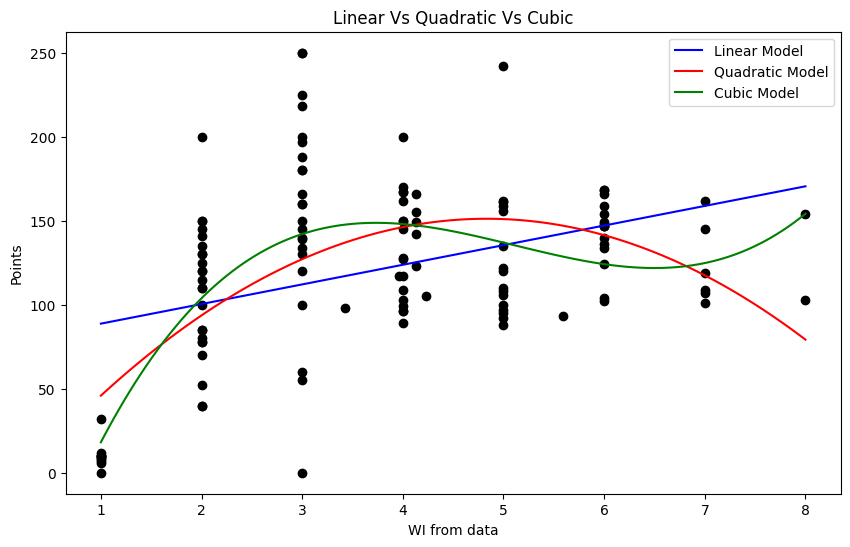

In [127]:
create_polynomial_plot(X_train_clean.WI, y_train)

Here the polynomial equation fit better than the linear.     
Let's create a set of polynomial features and apply a linear regression on it.

In [128]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train_clean)

poly.fit(X_poly, y_train)

PolynomialFeatures()

In [129]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

lm.fit(X_poly, y_train)

LinearRegression()

In [130]:
predictions = lm.predict(poly.fit_transform(test))

In [131]:
print("R2 score is ", metrics.r2_score(y_test, predictions))

R2 score is  0.06790842348899828


In [132]:
print('RMSE of the model is ', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE of the model is  47.37648288950229


In [134]:
# append the PolynomialFeature_degree2 results to metrics_df
d = {'model_name': 'PolynomialFeature_degree2', 'model_summary': 'No summary', 'mean_absolute_error': mean_absolute_error(y_test, predictions), 'rmse': np.sqrt(mean_squared_error(y_test, predictions)), 'r2_score': metrics.r2_score(y_test, predictions)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908


let's analyze the R2 and RMSE for the polynomial degree 3 and 4

In [135]:
print("for degree 3")
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train_clean)

poly.fit(X_poly, y_train)

from sklearn import linear_model
lm = linear_model.LinearRegression()

lm.fit(X_poly, y_train)

predictions = lm.predict(poly.fit_transform(test))

print("R2 score is ", metrics.r2_score(y_test, predictions))
print('RMSE of the model is ', np.sqrt(mean_squared_error(y_test, predictions)))

for degree 3
R2 score is  -286.3582801103667
RMSE of the model is  831.8506932767372


In [136]:
# append the PolynomialFeature_degree2 results to metrics_df
d = {'model_name': 'PolynomialFeature_degree3', 'model_summary': 'No summary', 'mean_absolute_error': mean_absolute_error(y_test, predictions), 'rmse': np.sqrt(mean_squared_error(y_test, predictions)), 'r2_score': metrics.r2_score(y_test, predictions)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280


In [137]:
print("for degree 4")
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_train_clean)

poly.fit(X_poly, y_train)

from sklearn import linear_model
lm = linear_model.LinearRegression()

lm.fit(X_poly, y_train)

predictions = lm.predict(poly.fit_transform(test))

print("R2 score is ", metrics.r2_score(y_test, predictions))
print('RMSE of the model is ', np.sqrt(mean_squared_error(y_test, predictions)))

for degree 4
R2 score is  -168.49065992373048
RMSE of the model is  638.8610492037357


In [138]:
# append the PolynomialFeature_degree2 results to metrics_df
d = {'model_name': 'PolynomialFeature_degree4', 'model_summary': 'No summary', 'mean_absolute_error': mean_absolute_error(y_test, predictions), 'rmse': np.sqrt(mean_squared_error(y_test, predictions)), 'r2_score': metrics.r2_score(y_test, predictions)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660


From the above errors for degree 2, 3, and 4, the polynomial regression model with degree 2 is better.

Here the polynomial regression results are not so good. Let's dive deeper and explore Piecewise Regression and Various Spline Regression techniques to improvise the previous results.

**Piecewise Regression**

Piecewise Regression, also known as Segmented Regression, is a regression analysis approach in which the independent variable is partitioned into intervals and each interval is fitted with different linear functions. The rationale behind piecewise linear regression is that if the data exhibits various linear trends over different portions of the data, the overall regression function can be modeled in multiple "pieces".     

Spline Regression or Spline Interpolation produces a piecewise continuous function made up of several polynomial regression functions.

In [140]:
#!pip install piecewise_regression

You should consider upgrading via the '/Users/saili/Library/CloudStorage/OneDrive-GeorgeMasonUniversity-O365Production/Bag/projects/sports-analytics-2/env/bin/python3 -m pip install --upgrade pip' command.


In [141]:
import piecewise_regression

In [142]:
# 2 dimensions
# 1 dependent and 1 independent variables
# X_train_clean must contain no missing values
X_train_clean.WL

140    48.0
136    40.0
43     20.0
114    35.0
105    25.0
       ... 
76     16.0
24     32.0
74     14.0
94     21.0
77     16.0
Name: WL, Length: 124, dtype: float64

In [143]:
y_train

140    109
136    149
43     150
114    127
105    250
      ... 
76      70
24     159
74      40
94     150
77     100
Name: Points, Length: 124, dtype: int64

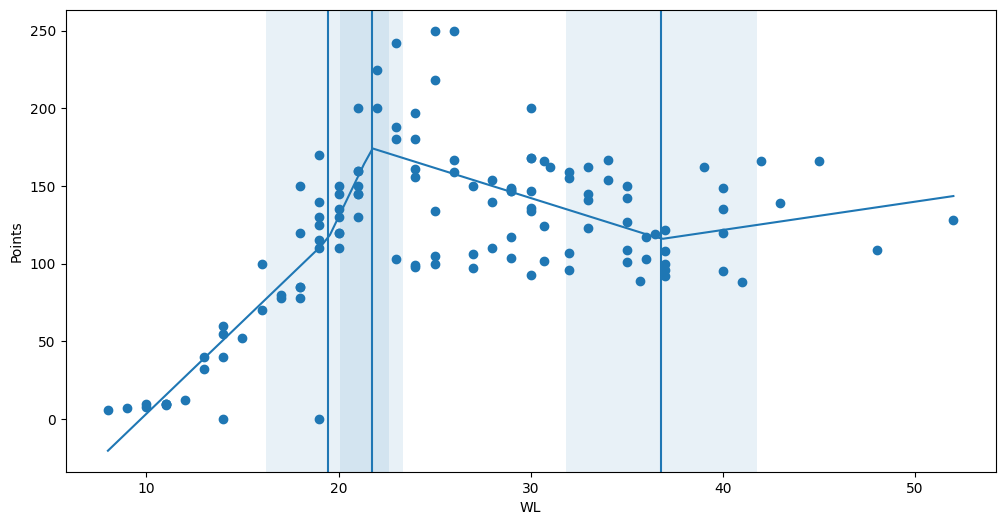

In [144]:
pw_fit = piecewise_regression.Fit(X_train_clean.WL.ravel(), y_train.ravel(), n_breakpoints=3)

pw_fit.plot()
plt.xlabel("WL")
plt.ylabel("Points")
plt.show()

In [145]:
print(pw_fit.summary())


                    Breakpoint Regression Results                     
No. Observations                      124
No. Model Parameters                    8
Degrees of Freedom                    116
Res. Sum of Squares           1.21687e+05
Total Sum of Squares          3.50669e+05
R Squared                        0.652986
Adjusted R Squared               0.628846
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -115.431         25.3      -4.5621      1.27e-05      -165.54      -65.317
alpha1               11.8806         1.65       7.2158      5.97e-11       8.6195       15.142
beta1                13.8337         17.4      0.79547             -      -20.611       48.278
beta2               -29.5936         17.3      -1.7066             -       -63.94       4.7525
beta3            

In [146]:
overall_model = piecewise_regression.ModelSelection(X_train_clean.WL.ravel(), y_train.ravel(), max_breakpoints=5)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     970.45         True   2.8744e+05 
1                      883.8         True   1.3221e+05 
2                     889.52         True   1.2811e+05 
3                     892.91         True    1.218e+05 
4                     901.05         True   1.2034e+05 
5                     910.22         True   1.1989e+05 

Min BIC (Bayesian Information Criterion) suggests best model


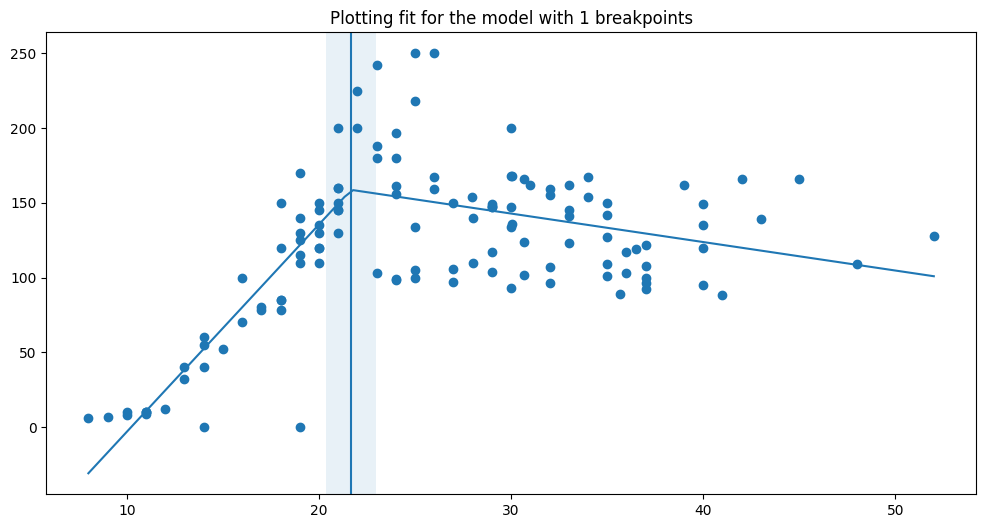

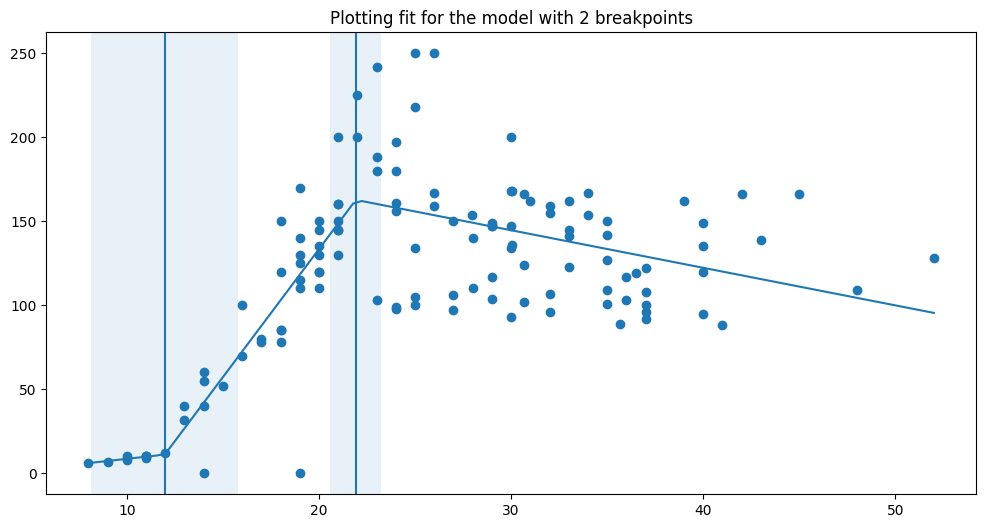

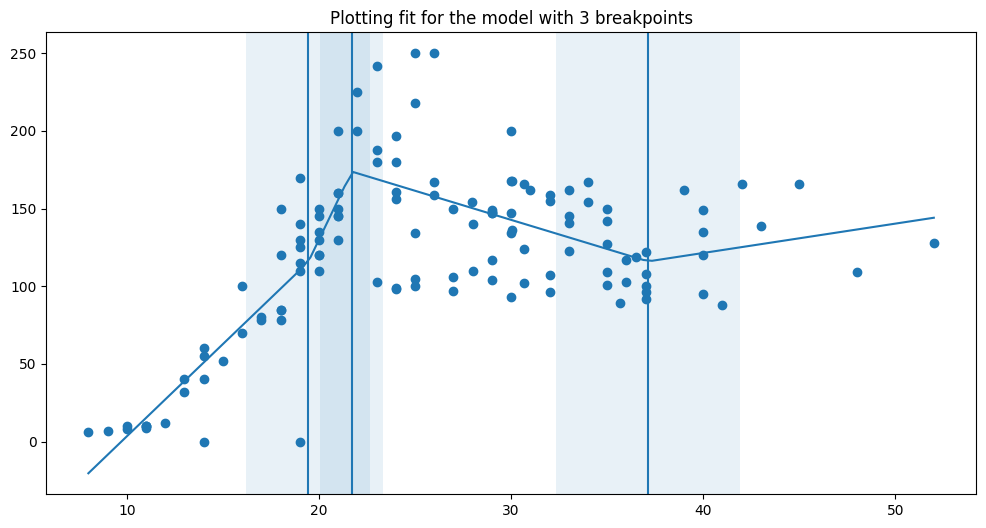

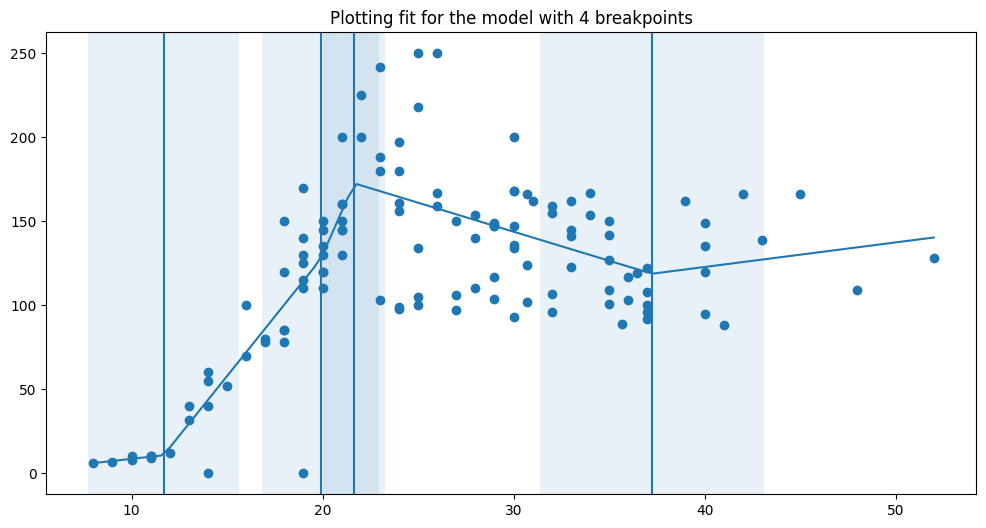

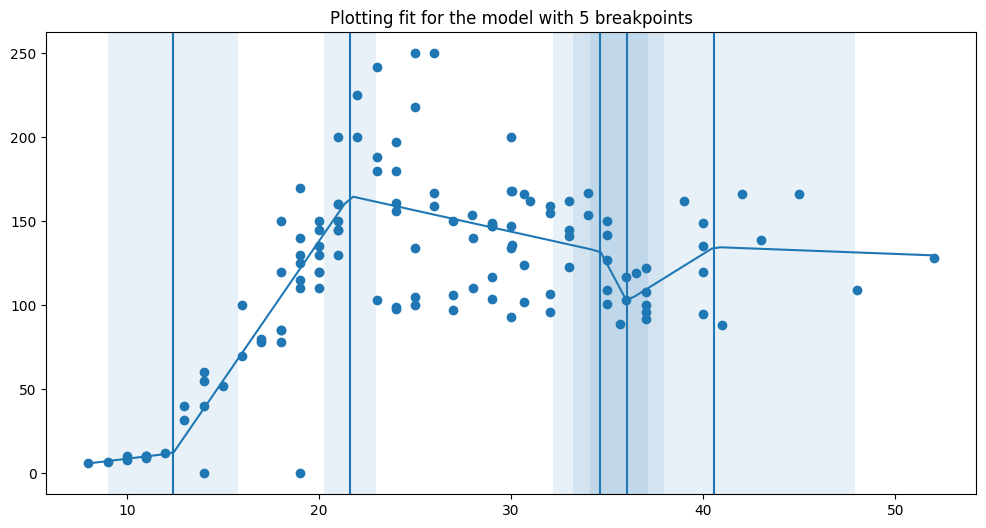

In [147]:
# plot the models
for model in overall_model.models:
    model.plot()
    plt.title("Plotting fit for the model with {} breakpoints".format(model.n_breakpoints))
    plt.show()

In [150]:
# since model with 1 breakpoint has min BIC value which suggest the best model
pw_fit = piecewise_regression.Fit(X_train_clean.WL.ravel(), y_train.ravel(), n_breakpoints=1)
pw_fit.get_results()

{'estimates': {'const': {'estimate': -141.9283551967711,
   'se': 21.01108489688846,
   'confidence_interval': (-183.52884102726574, -100.32786936627645),
   't_stat': -6.7549275010444285,
   'p_t': 5.434572930419978e-10},
  'beta1': {'estimate': -15.775682642996648,
   'se': 1.356883715122353,
   'confidence_interval': (-18.462217966688364, -13.089147319304931),
   't_stat': -11.626407235327548,
   'p_t': '-'},
  'breakpoint1': {'estimate': 21.671273785974954,
   'se': 0.6607621002608529,
   'confidence_interval': (20.36301081316196, 22.979536758787948),
   't_stat': '-',
   'p_t': '-'},
  'alpha1': {'estimate': 13.869828456104939,
   'se': 1.2125704196576184,
   'confidence_interval': (11.469023413957215, 16.270633498252664),
   't_stat': 11.438369459829993,
   'p_t': 6.123799092772851e-21},
  'alpha2': {'estimate': -1.905854186891709,
   'se': 0.608938743828622,
   'confidence_interval': (-3.1115105206126414, -0.7001978531707764),
   't_stat': -3.129796233540507,
   'p_t': 0.0021967

In [151]:
!git clone https://github.com/DataDog/piecewise.git

Cloning into 'piecewise'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Receiving objects: 100% (77/77), 48.14 KiB | 735.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [152]:
import sys
sys.path.append('piecewise/')

In [ ]:
!python piecewise/setup.py install

In [155]:
from piecewise.regressor import piecewise

In [156]:
model_piecewise = piecewise(X_train_clean.WL.ravel(), y_train.ravel())
model_piecewise

FittedModel with segments:
* FittedSegment(start_t=8.0, end_t=22.0, coeffs=(-131.31906025009468, 13.104016672982189))
* FittedSegment(start_t=22.0, end_t=52.0, coeffs=(211.7604273201847, -2.2363878150836953))

In [157]:
len(model_piecewise.segments)

2

In [159]:
y_pred = model_piecewise.predict(test.WL.ravel())
y_pred

array([104.55323986, 143.86528988, 126.77769035, 122.30491472,
        91.44922319, 129.01407816, 151.37795631, 140.91322402,
       158.08711976, 131.25046598, 135.72324161,  39.0331565 ,
       162.55989539, 162.55989539, 162.55989539, 143.86528988,
       149.1415685 , 162.55989539, 140.19601724, 122.30491472,
       158.08711976,  12.82512315, 117.65725654, 117.65725654,
       155.85073194,  78.34520652,  -0.27889352, 135.72324161,
       117.65725654,  25.92913983, 130.16410341,  25.92913983])

In [163]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("r2_score ", r2_score(y_test, y_pred))
print("rmse ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mae ", mean_absolute_error(y_test, y_pred))

r2_score  0.8465659435522811
rmse  19.22181568434294
mae  14.906760093704118


In [164]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Piecewise_regression_1breakpoint', 'model_summary': model_piecewise, 'mean_absolute_error': mean_absolute_error(y_test, y_pred), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred)), 'r2_score': metrics.r2_score(y_test, y_pred)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566


**Splines Regression**

In [165]:
from patsy import dmatrix

In [166]:
X_spline = dmatrix('bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)', return_type='dataframe')
X_spline

,Intercept,"bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[0]","bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[1]","bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[2]","bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[3]","bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[4]"
140,1.0,0.000000,0.002133,0.060956,0.389203,0.547708
136,1.0,0.000000,0.057585,0.378944,0.469557,0.093914
43,1.0,0.228456,0.633772,0.137317,0.000000,0.000000
114,1.0,0.000000,0.163723,0.547711,0.276827,0.011739
105,1.0,0.028696,0.598533,0.365371,0.007400,0.000000
...,...,...,...,...,...,...
76,1.0,0.490857,0.411560,0.040687,0.000000,0.000000
24,1.0,0.000000,0.266596,0.581350,0.151303,0.000751
74,1.0,0.558681,0.268033,0.017165,0.000000,0.000000
94,1.0,0.167355,0.658058,0.174587,0.000000,0.000000


In [170]:
spline_fit = sm.GLM(y_train, X_spline).fit()
spline_fit

In [171]:
spline_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Points   No. Observations:                  124
Model:                            GLM   Df Residuals:                      118
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                          1072.1
Method:                          IRLS   Log-Likelihood:                -605.47
Date:                Tue, 20 Jun 2023   Deviance:                   1.2651e+05
Time:                        13:04:57   Pearson chi2:                 1.27e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8150
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           19.9708     21.912      0.911      0.362     -22.976      62.917
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[0]   -62.9243     39.520     -1.592      0.111    -140.383      14.534
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[1]   194.6126     21.466      9.066      0.000     152.541     236.684
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[2]    70.1370     32.690      2.146      0.032       6.066     134.208
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[3]   122.0583     33.033      3.695      0.000      57.316     186.801
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[4]   108.9416     37.506      2.905      0.004      35.431     182.452
====================================================================================================================================
"""

In [172]:
spline_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Results: Generalized linear model
====================================================================================================================
Model:                                GLM                               AIC:                             1222.9435  
Link Function:                        Identity                          BIC:                             125941.3862
Dependent Variable:                   Points                            Log-Likelihood:                  -605.47    
Date:                                 2023-06-20 13:06                  LL-Null:                         -710.09    
No. Observations:                     124                               Deviance:                        1.2651e+05 
Df Model:                             5                                 Pearson chi2:                    1.27e+05   
Df Residuals:                         118                               Scale:                           1072.1     
Method:                               IRLS                                                                          
--------------------------------------------------------------------------------------------------------------------
                                                                  Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
--------------------------------------------------------------------------------------------------------------------
Intercept                                                         19.9708  21.9119  0.9114 0.3621  -22.9758  62.9174
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[0] -62.9243  39.5205 -1.5922 0.1113 -140.3830  14.5344
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[1] 194.6126  21.4655  9.0663 0.0000  152.5410 236.6842
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[2]  70.1370  32.6900  2.1455 0.0319    6.0657 134.2083
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[3] 122.0583  33.0325  3.6951 0.0002   57.3158 186.8008
bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)[4] 108.9416  37.5061  2.9046 0.0037   35.4310 182.4523
====================================================================================================================

"""

In [174]:
y_pred_train = spline_fit.predict(dmatrix('bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)', return_type='dataframe'))
y_pred_train

140    131.834837
136    125.300016
43     138.566389
114    125.316086
105    161.176435
          ...    
76      72.032451
24     131.177457
74      38.182627
94     149.751432
77      72.032451
Length: 124, dtype: float64

In [175]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse

31.941248922533223

In [176]:
r2 = r2_score(y_train, y_pred_train)
r2

0.6392321176321569

In [177]:
mae = mean_absolute_error(y_train, y_pred_train)
mae

23.356767049961526

In [181]:
y_pred_test = spline_fit.predict(dmatrix('bs(test.WL, df=5, degree=3, include_intercept=False)', return_type='dataframe'))
y_pred_test

38     110.892588
46     151.909598
34     132.178312
134    128.912444
36      88.926216
119    131.929397
6      132.596809
18     123.642307
55     150.549766
132    130.829966
113    127.291713
157     11.230596
97     155.037057
48     155.037057
95     155.037057
92     151.909598
108    127.780582
49     155.037057
25     123.987860
135    128.912444
1      150.549766
153      6.651486
39     129.852122
41     129.852122
104    145.019482
63      65.964918
147     19.970800
59     127.291713
42     129.852122
154      4.408722
122    131.451157
155      4.408722
dtype: float64

In [183]:
#rmse
np.sqrt(mean_squared_error(y_test, y_pred_test))

21.04712560370615

In [184]:
r2_score(y_test, y_pred_test)

0.8160420608834353

In [185]:
mean_absolute_error(y_test, y_pred_test)

17.495960345097615

In [188]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Splines_5df_3degree_Falseintercept', 'model_summary': spline_fit.summary2(), 'mean_absolute_error': mean_absolute_error(y_test, y_pred_test), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)), 'r2_score': metrics.r2_score(y_test, y_pred_test)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566
5,Splines_5df_3degree_Falseintercept,Resul...,17.495960,21.047126,0.816042


In [189]:
X_spline = dmatrix('bs(X_train_clean.WL, df=5, degree=3, include_intercept=True)', return_type='dataframe')
spline_fit = sm.GLM(y_train, X_spline).fit()
print(spline_fit.summary())
print(spline_fit.summary2())
y_pred_test = spline_fit.predict(dmatrix('bs(test.WL, df=5, degree=3, include_intercept=True)', return_type='dataframe'))
print("rmse ", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("mae ", mean_absolute_error(y_test, y_pred_test))
print("r2_score ", r2_score(y_test, y_pred_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Points   No. Observations:                  124
Model:                            GLM   Df Residuals:                      119
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                          1238.5
Method:                          IRLS   Log-Likelihood:                -614.94
Date:                Tue, 20 Jun 2023   Deviance:                   1.4738e+05
Time:                        13:22:17   Pearson chi2:                 1.47e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7341
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [190]:
print(spline_fit.summary2())

                                         Results: Generalized linear model
Model:                                GLM                               AIC:                             1239.8750  
Link Function:                        Identity                          BIC:                             146803.7026
Dependent Variable:                   Points                            Log-Likelihood:                  -614.94    
Date:                                 2023-06-20 13:22                  LL-Null:                         -697.06    
No. Observations:                     124                               Deviance:                        1.4738e+05 
Df Model:                             4                                 Pearson chi2:                    1.47e+05   
Df Residuals:                         119                               Scale:                           1238.5     
Method:                               IRLS                                                                

In [191]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Splines_5df_3degree_Trueintercept', 'model_summary': spline_fit.summary2(), 'mean_absolute_error': mean_absolute_error(y_test, y_pred_test), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)), 'r2_score': metrics.r2_score(y_test, y_pred_test)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566
5,Splines_5df_3degree_Falseintercept,Resul...,17.495960,21.047126,0.816042
6,Splines_5df_3degree_Trueintercept,Resul...,23.907075,30.641945,0.610089


In [204]:
X_spline = dmatrix('bs(X_train_clean.WL, df=6, degree=3, include_intercept=False)', return_type='dataframe')
spline_fit = sm.GLM(y_train, X_spline).fit()
print(spline_fit.summary())
print(spline_fit.summary2())
y_pred_test = spline_fit.predict(dmatrix('bs(test.WL, df=6, degree=3, include_intercept=False)', return_type='dataframe'))
print("rmse ", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("mae ", mean_absolute_error(y_test, y_pred_test))
print("r2_score ", r2_score(y_test, y_pred_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Points   No. Observations:                  124
Model:                            GLM   Df Residuals:                      117
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1091.7
Method:                          IRLS   Log-Likelihood:                -606.06
Date:                Tue, 20 Jun 2023   Deviance:                   1.2773e+05
Time:                        13:28:04   Pearson chi2:                 1.28e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8077
Covariance Type:            nonrobust                                         
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [205]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Splines_6df_3degree_Falseintercept', 'model_summary': spline_fit.summary2(), 'mean_absolute_error': mean_absolute_error(y_test, y_pred_test), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)), 'r2_score': metrics.r2_score(y_test, y_pred_test)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566
5,Splines_5df_3degree_Falseintercept,Resul...,17.495960,21.047126,0.816042
6,Splines_5df_3degree_Trueintercept,Resul...,23.907075,30.641945,0.610089
7,Splines_6df_3degree_Falseintercept,Resul...,18.573518,22.754806,0.784980


In [206]:
X_spline = dmatrix('bs(X_train_clean.WL, df=6, degree=3, include_intercept=True)', return_type='dataframe')
spline_fit = sm.GLM(y_train, X_spline).fit()
print(spline_fit.summary())
print(spline_fit.summary2())
y_pred_test = spline_fit.predict(dmatrix('bs(test.WL, df=6, degree=3, include_intercept=True)', return_type='dataframe'))
print("rmse ", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("mae ", mean_absolute_error(y_test, y_pred_test))
print("r2_score ", r2_score(y_test, y_pred_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Points   No. Observations:                  124
Model:                            GLM   Df Residuals:                      118
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                          1078.5
Method:                          IRLS   Log-Likelihood:                -605.47
Date:                Tue, 20 Jun 2023   Deviance:                   1.2651e+05
Time:                        13:28:36   Pearson chi2:                 1.27e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8132
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [207]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Splines_6df_3degree_Trueintercept', 'model_summary': spline_fit.summary2(), 'mean_absolute_error': mean_absolute_error(y_test, y_pred_test), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)), 'r2_score': metrics.r2_score(y_test, y_pred_test)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566
5,Splines_5df_3degree_Falseintercept,Resul...,17.495960,21.047126,0.816042
6,Splines_5df_3degree_Trueintercept,Resul...,23.907075,30.641945,0.610089
7,Splines_6df_3degree_Falseintercept,Resul...,18.573518,22.754806,0.784980
8,Splines_6df_3degree_Trueintercept,Resul...,17.495960,21.047126,0.816042


In [212]:
# comparing the actual vs predictions
comparison = pd.concat([X_train_clean.WL, y_train, y_pred_train], axis=1)
comparison.columns = ['WL', 'Real/Actual Points', 'Fitted Points']
print(comparison)

       WL  Real/Actual Points  Fitted Points
140  48.0                 109     131.834837
136  40.0                 149     125.300016
43   20.0                 150     138.566389
114  35.0                 127     125.316086
105  25.0                 250     161.176435
..    ...                 ...            ...
76   16.0                  70      72.032451
24   32.0                 159     131.177457
74   14.0                  40      38.182627
94   21.0                 150     149.751432
77   16.0                 100      72.032451

[124 rows x 3 columns]


In [213]:
comparison = pd.concat([test.WL, y_test, y_pred_test], axis=1)
comparison.columns = ['WL', 'Real/Actual Points', 'Predicted Points']
print(comparison)

            WL  Real/Actual Points  Predicted Points
38   18.000000                  87        133.525528
46   21.000000                 140        159.723767
34   38.000000                 109        141.433251
134  40.000000                 105        120.117445
36   17.000000                  69        114.727408
119  37.000000                 141        144.088402
6    27.000000                 158        128.994593
18   31.679301                 155        122.961679
55   24.000000                  89        149.840645
132  36.000000                 116        142.938377
113  34.000000                 149        134.141363
157  13.000000                  20         17.211670
97   22.000000                 145        159.351709
48   22.000000                 169        159.351709
95   22.000000                 170        159.351709
92   21.000000                 150        159.723767
108  28.000000                 124        123.884980
49   22.000000                 161        159.

In [226]:
X_spline = dmatrix('bs(X_train_clean.WL, df=5, degree=3, include_intercept=False)', return_type='dataframe')
spline_fit = sm.GLM(y_train, X_spline).fit()

In [228]:
# plotting the spline
range_pred = np.linspace(np.min(X_train_clean.WL), np.max(X_train_clean.WL), 50)
prediction = spline_fit.predict(dmatrix('bs(range_pred, df=5, degree=3, include_intercept = False)', return_type='dataframe'))
prediction

0      19.970800
1      10.505393
2       4.970097
3       2.983734
4       4.165124
5       8.133089
6      14.506450
7      22.904029
8      32.944646
9      44.247122
10     56.430279
11     69.112938
12     81.913921
13     94.452047
14    106.346139
15    117.215018
16    126.677504
17    134.379325
18    140.278987
19    144.536790
20    147.316395
21    148.781466
22    149.095664
23    148.422653
24    146.926096
25    144.769653
26    142.116989
27    139.131766
28    135.977646
29    132.818292
30    129.817367
31    127.138532
32    124.945451
33    123.400157
34    122.566938
35    122.358579
36    122.674830
37    123.415443
38    124.480169
39    125.768759
40    127.180964
41    128.616536
42    129.975225
43    131.156784
44    132.060962
45    132.587511
46    132.636183
47    132.106728
48    130.898898
49    128.912444
dtype: float64

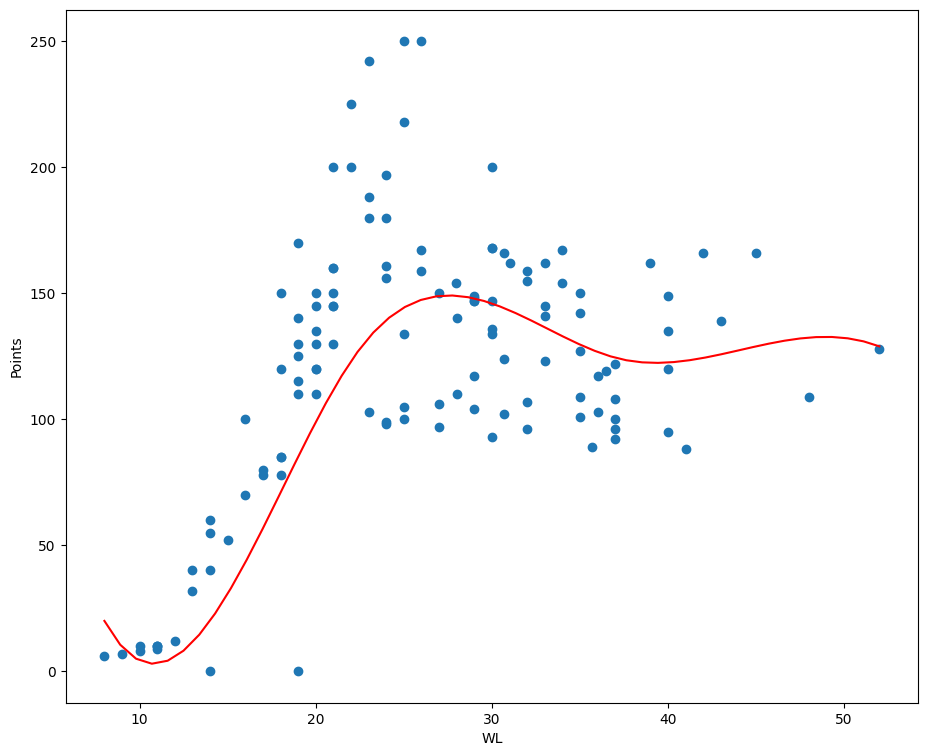

In [230]:
plt.figure(figsize=(11,9))
plt.scatter(X_train_clean.WL, y_train, marker = 'o')
plt.plot(range_pred, prediction, color='r', label='5 knots and 3 degrees')
plt.xlabel('WL')
plt.ylabel('Points')
plt.show()

**Applying splines on 2 variables for surface smoothing**

In [232]:
from mpl_toolkits.mplot3d import Axes3D
from csaps import csaps

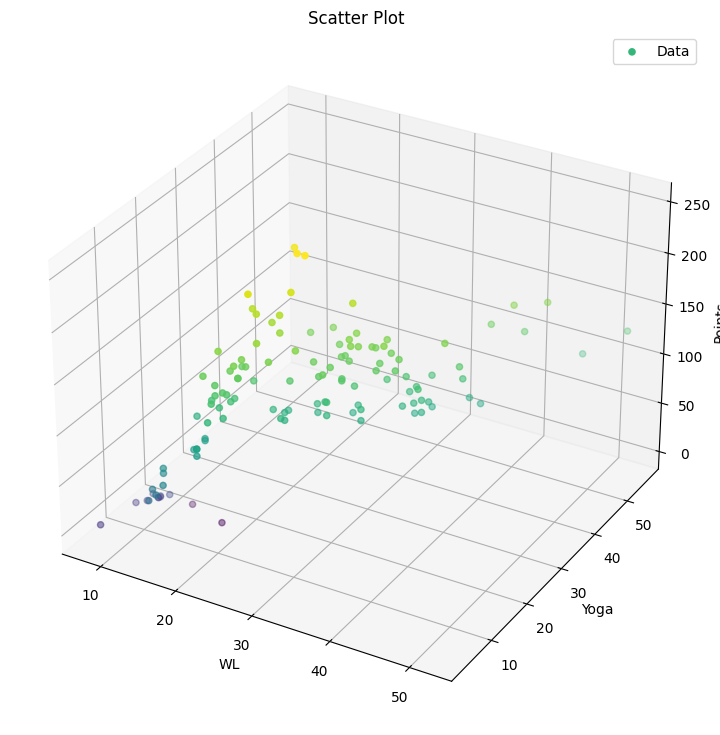

In [238]:
# plot the data in 3d
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_train_clean.WL,
            X_train_clean.Yoga,
            y_train,
            c = np.sqrt(y_train),
            label = 'Data')
ax.set_title('Scatter Plot')
ax.set_xlabel('WL')
ax.set_ylabel('Yoga')
ax.set_zlabel('Points')
plt.legend(loc='upper right')
plt.show()

In [241]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

In [242]:
spline_model = make_pipeline(SplineTransformer(n_knots=5, degree=3),
                            LinearRegression())
spline_model

Pipeline(steps=[('splinetransformer', SplineTransformer()),
                ('linearregression', LinearRegression())])

In [244]:
spline_model.fit(X_train_clean[['WL', 'Yoga']], y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer()),
                ('linearregression', LinearRegression())])

In [252]:
spline_model_fit = spline_model.predict(X_train_clean[['WL', 'Yoga']])

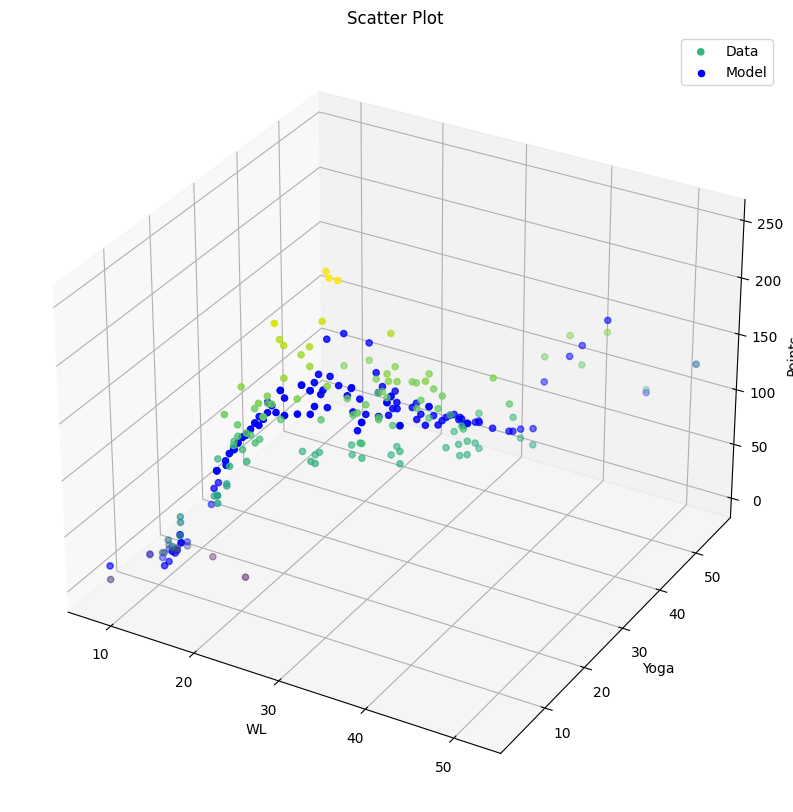

In [253]:
# plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_train_clean.WL,
            X_train_clean.Yoga,
            y_train,
            c = np.sqrt(y_train),
            label = 'Data')

ax.scatter(X_train_clean.WL,
            X_train_clean.Yoga,
            spline_model_fit,
            c = 'blue',
            label = 'Model')

ax.set_title('Scatter Plot')
ax.set_xlabel('WL')
ax.set_ylabel('Yoga')
ax.set_zlabel('Points')
plt.legend(loc='upper right')

ax = plt.gca()
plt.show()

In [254]:
y_pred = spline_model.predict(test[['WL', 'Yoga']])
y_pred

array([112.71287155, 138.90214553, 123.23842546, 113.36216132,
        94.7028451 , 123.88574103, 155.97523979, 138.44781671,
       166.89329364, 123.35163029, 128.81553076,  30.00196554,
       161.95037898, 147.91269653, 143.11399624, 148.55377857,
       145.37053478, 141.23738338, 132.69812745, 113.36216132,
       182.7974948 ,   7.42952767, 128.12556761, 122.46861278,
       156.18195894,  75.32376844,   3.42804222, 130.44891537,
       121.18955678,  13.92290354, 124.38493846,  13.92290354])

In [255]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

21.987834634236805

In [256]:
mae = mean_absolute_error(y_test, y_pred)
mae

16.43023421032069

In [257]:
r2 = r2_score(y_test, y_pred)
r2

0.7992304368517638

In [260]:
# append the Piecewise_regression_1breakpoint results to metrics_df
d = {'model_name': 'Splines_WL_Yoga', 'model_summary': spline_model.get_params(), 'mean_absolute_error': mean_absolute_error(y_test, y_pred), 'rmse': np.sqrt(mean_squared_error(y_test, y_pred)), 'r2_score': metrics.r2_score(y_test, y_pred)}

metrics_df = metrics_df.append(d, ignore_index=True)
metrics_df


,model_name,model_summary,mean_absolute_error,rmse,r2_score
0,linear_regression,OLS Regression Res...,22.535648,27.906740,0.676592
1,PolynomialFeature_degree2,No summary,35.072727,47.376483,0.067908
2,PolynomialFeature_degree3,No summary,358.716714,831.850693,-286.358280
3,PolynomialFeature_degree4,No summary,295.410350,638.861049,-168.490660
4,Piecewise_regression_1breakpoint,FittedModel with segments:\n* FittedSegment(st...,14.906760,19.221816,0.846566
5,Splines_5df_3degree_Falseintercept,Resul...,17.495960,21.047126,0.816042
6,Splines_5df_3degree_Trueintercept,Resul...,23.907075,30.641945,0.610089
7,Splines_6df_3degree_Falseintercept,Resul...,18.573518,22.754806,0.784980
8,Splines_6df_3degree_Trueintercept,Resul...,17.495960,21.047126,0.816042
9,Splines_WL_Yoga,"{'memory': None, 'steps': [('splinetransformer...",16.430234,21.987835,0.799230


**Problem here is**      
1. Too many models
2. How do you know which spline is fitting the data best?

**MARS - Multivariate Adaptive Regression Splines**

In [305]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from pyearth import Earth

ModuleNotFoundError: No module named 'pyearth'